**PHASE 5: PREDICTIVE/RECOMMENDATION FEATURES**


---



# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from itertools import combinations
from collections import Counter
warnings.filterwarnings('ignore')

# General Methods and Tools

In [ ]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
#colors:
#pastels: colors = ["#DDA0DD", "#90EE90", "#FFB6C1", "#ADD8E6"]
#Gender color palette: ['skyblue', '#FC8EAC']

#For printing headers
def print_header(heading, border_char="=", width=100):
    black = "\033[30m"
    bold = "\033[1m"
    reset = "\033[0m"

    print()
    print(border_char * width)
    print(f"{bold}{black}{heading.center(width)}{reset}")
    print(border_char * width)

#For subheaders
def print_dashed_heading(heading, border_char="=", text_color="\033[30m", border_color="\033[35m"):
    print()
    border = border_color + border_char * (len(heading) + 25) + "\033[0m"
    print(border)
    print(f"{border_color}{text_color}      {heading} \033[0m{border_color}\033[0m")
    print(border)


#For results
def print_heading_3(heading, text_color="\033[35m", border_char="-"):
    print()
    print(f"{text_color}{heading}\033[0m")  # Print the heading in dark blue
    print(border_char * len(heading))  # Dash line just below the heading



# Load Data

In [ ]:
#Load all data
try:
    patients = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/patients.csv")
    vitals = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/vitals.csv")
    drugs = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/drugs.csv")
    hospitals = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/hospitals.csv")
    hospital_patient = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/hospital_patient.csv")
    medical_tests = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/medical_tests.csv")
    medical_parameters = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/medical_parameters.csv")
    allergies = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/allergies.csv")
    drug_records = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/drug_records.csv")
    drug_patient = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/drug_patient.csv")
    medical_results = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/medical_results.csv")
    surgeries = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/surgeries.csv")
    users = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/users.csv")
    devices = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/devices.csv")
    doctors = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/doctors.csv")
    doctor_hospital = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/doctor_hospital.csv")
    appointments = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/appointments.csv")
except Exception as e:
    print(e)
else:
  print_header("Data Loaded Successfully")


                                      Data Loaded Successfully                                      


# Data Cleaning: Removing the ouliers in vitals before analysis + Data Preparation

In [ ]:
def clean_vitals_data(vitals_df, verbose=True):
    """
    Clean vitals data by intelligently correcting physiologically impossible values
    based on context from other vital signs. This approach distinguishes between
    data entry errors and genuine medical emergencies, preserving ALL data while
    ensuring values are medically plausible.

    Parameters:
    -----------
    vitals_df : pandas.DataFrame
        Raw vitals dataframe with columns: temperature, pressure, heartbeat, oxygen, glucose
    verbose : bool
        If True, print detailed cleaning statistics

    Returns:
    --------
    pandas.DataFrame
        Cleaned vitals dataframe with intelligent corrections applied
    """

    if verbose:
        print_dashed_heading("Vitals Data Cleaning - Intelligent Medical Correction")
        print_heading_3(f"Original dataset: {len(vitals_df):,} vital sign records")

    # Create a copy to avoid modifying original data
    cleaned_vitals = vitals_df.copy()

    # Track cleaning statistics
    cleaning_stats = {
        'original_records': len(cleaned_vitals),
        'corrected_values': {},
        'invalid_formats_fixed': {},
        'death_cases_preserved': 0,
        'data_errors_corrected': 0,
        'critical_but_viable_corrections': 0
    }

    # Helper function to assess if other vitals suggest patient is alive
    def is_patient_viable(row, exclude_column=None):
        """
        Determine if a patient appears viable based on other vital signs
        Returns: 'normal', 'critical', or 'dead'
        """
        # Extract vitals (excluding the one we're checking)
        hr = row.get('heartbeat') if exclude_column != 'heartbeat' else None
        temp = row.get('temperature') if exclude_column != 'temperature' else None
        o2 = row.get('oxygen') if exclude_column != 'oxygen' else None
        glucose = row.get('glucose') if exclude_column != 'glucose' else None

        # Define normal ranges
        normal_hr = (60, 120)
        normal_temp = (36, 38)
        normal_o2 = (95, 100)
        normal_glucose = (70, 180)

        # Count how many vitals are in normal, critical, or death ranges
        normal_count = 0
        critical_count = 0
        death_indicators = 0
        total_vitals = 0

        if hr is not None and pd.notna(hr):
            total_vitals += 1
            if normal_hr[0] <= hr <= normal_hr[1]:
                normal_count += 1
            elif 30 <= hr < normal_hr[0] or normal_hr[1] < hr <= 200:
                critical_count += 1
            elif hr < 30 or hr > 200:
                death_indicators += 1

        if temp is not None and pd.notna(temp):
            total_vitals += 1
            if normal_temp[0] <= temp <= normal_temp[1]:
                normal_count += 1
            elif 34 <= temp < normal_temp[0] or normal_temp[1] < temp <= 42:
                critical_count += 1
            elif temp < 34 or temp > 42:
                death_indicators += 1

        if o2 is not None and pd.notna(o2):
            total_vitals += 1
            if normal_o2[0] <= o2 <= normal_o2[1]:
                normal_count += 1
            elif 70 <= o2 < normal_o2[0]:
                critical_count += 1
            elif o2 < 70:
                death_indicators += 1

        if glucose is not None and pd.notna(glucose):
            total_vitals += 1
            if normal_glucose[0] <= glucose <= normal_glucose[1]:
                normal_count += 1
            elif 40 <= glucose < normal_glucose[0] or normal_glucose[1] < glucose <= 400:
                critical_count += 1
            elif glucose < 40 or glucose > 400:
                death_indicators += 1

        # Decision logic
        if total_vitals == 0:
            return 'normal'  # No other vitals to judge by

        # If majority of vitals suggest death
        if death_indicators >= total_vitals * 0.6:
            return 'dead'
        # If majority are normal
        elif normal_count >= total_vitals * 0.6:
            return 'normal'
        # Otherwise critical but viable
        else:
            return 'critical'

    # =============================================================================
    # OXYGEN SATURATION INTELLIGENT CORRECTION
    # =============================================================================
    if 'oxygen' in cleaned_vitals.columns:
        o2_col = 'oxygen'
        original_count = cleaned_vitals[o2_col].notna().sum()
        corrections = {'data_errors': 0, 'critical_viable': 0, 'death_preserved': 0}

        if original_count > 0:
            for idx, row in cleaned_vitals.iterrows():
                o2_value = row[o2_col]
                if pd.notna(o2_value):
                    # Handle values outside possible range (0-100)
                    if o2_value > 100:
                        cleaned_vitals.loc[idx, o2_col] = 98  # Normal baseline
                        corrections['data_errors'] += 1
                    elif o2_value < 0:
                        cleaned_vitals.loc[idx, o2_col] = 98  # Normal baseline
                        corrections['data_errors'] += 1
                    # Handle critically low values (0-50)
                    elif o2_value <= 50:
                        patient_status = is_patient_viable(row, exclude_column='oxygen')
                        if patient_status == 'normal':
                            cleaned_vitals.loc[idx, o2_col] = 98  # Normal baseline
                            corrections['data_errors'] += 1
                        elif patient_status == 'dead':
                            # Keep as is if truly indicates death
                            if o2_value == 0:
                                corrections['death_preserved'] += 1
                            else:
                                cleaned_vitals.loc[idx, o2_col] = 0  # Standardize death indicator
                                corrections['death_preserved'] += 1
                        else:  # critical but viable
                            cleaned_vitals.loc[idx, o2_col] = 88  # Low but plausible
                            corrections['critical_viable'] += 1

        cleaning_stats['corrected_values']['oxygen'] = corrections

        if verbose and sum(corrections.values()) > 0:
            print_heading_3(f"OXYGEN SATURATION CORRECTION:")
            print(f"   • Normal range target: 95-100% (baseline: 98%)")
            print(f"   • Critical viable range: 70-94% (correction: 88%)")
            print(f"   • Data errors corrected to normal: {corrections['data_errors']:,}")
            print(f"   • Critical but viable corrections: {corrections['critical_viable']:,}")
            print(f"   • Death cases preserved: {corrections['death_preserved']:,}")

    # =============================================================================
    # BLOOD GLUCOSE INTELLIGENT CORRECTION
    # =============================================================================
    if 'glucose' in cleaned_vitals.columns:
        glucose_col = 'glucose'
        original_count = cleaned_vitals[glucose_col].notna().sum()
        corrections = {'data_errors': 0, 'critical_viable': 0, 'death_preserved': 0}

        if original_count > 0:
            for idx, row in cleaned_vitals.iterrows():
                glucose_value = row[glucose_col]
                if pd.notna(glucose_value):
                    # Handle impossible values
                    if glucose_value > 800:
                        cleaned_vitals.loc[idx, glucose_col] = 100  # Normal baseline
                        corrections['data_errors'] += 1
                    elif glucose_value < 0:
                        cleaned_vitals.loc[idx, glucose_col] = 100  # Normal baseline
                        corrections['data_errors'] += 1
                    # Handle critically low values (0-30)
                    elif glucose_value <= 30:
                        patient_status = is_patient_viable(row, exclude_column='glucose')
                        if patient_status == 'normal':
                            cleaned_vitals.loc[idx, glucose_col] = 100  # Normal baseline
                            corrections['data_errors'] += 1
                        elif patient_status == 'dead':
                            cleaned_vitals.loc[idx, glucose_col] = 15  # Death-consistent value
                            corrections['death_preserved'] += 1
                        else:  # critical but viable
                            cleaned_vitals.loc[idx, glucose_col] = 60  # Low but plausible
                            corrections['critical_viable'] += 1

        cleaning_stats['corrected_values']['glucose'] = corrections

        if verbose and sum(corrections.values()) > 0:
            print_heading_3(f"BLOOD GLUCOSE CORRECTION:")
            print(f"   • Normal range target: 70-180 mg/dL (baseline: 100 mg/dL)")
            print(f"   • Critical viable range: 40-69 mg/dL (correction: 60 mg/dL)")
            print(f"   • Data errors corrected to normal: {corrections['data_errors']:,}")
            print(f"   • Critical but viable corrections: {corrections['critical_viable']:,}")
            print(f"   • Death cases preserved: {corrections['death_preserved']:,}")

    # =============================================================================
    # TEMPERATURE INTELLIGENT CORRECTION
    # =============================================================================
    if 'temperature' in cleaned_vitals.columns:
        temp_col = 'temperature'
        original_count = cleaned_vitals[temp_col].notna().sum()
        corrections = {'data_errors': 0, 'critical_viable': 0, 'death_preserved': 0}

        if original_count > 0:
            for idx, row in cleaned_vitals.iterrows():
                temp_value = row[temp_col]
                if pd.notna(temp_value):
                    # Handle impossible values
                    if temp_value > 45 or temp_value < 25:
                        cleaned_vitals.loc[idx, temp_col] = 37.0  # Normal baseline
                        corrections['data_errors'] += 1
                    # Handle critically low values (<34)
                    elif temp_value < 34:
                        patient_status = is_patient_viable(row, exclude_column='temperature')
                        if patient_status == 'normal':
                            cleaned_vitals.loc[idx, temp_col] = 37.0  # Normal baseline
                            corrections['data_errors'] += 1
                        elif patient_status == 'dead':
                            cleaned_vitals.loc[idx, temp_col] = 30.0  # Death-consistent value
                            corrections['death_preserved'] += 1
                        else:  # critical but viable
                            cleaned_vitals.loc[idx, temp_col] = 35.0  # Low but plausible
                            corrections['critical_viable'] += 1

        cleaning_stats['corrected_values']['temperature'] = corrections

        if verbose and sum(corrections.values()) > 0:
            print_heading_3(f"TEMPERATURE CORRECTION:")
            print(f"   • Normal range target: 36-38°C (baseline: 37°C)")
            print(f"   • Critical viable range: 34-36°C (correction: 35°C)")
            print(f"   • Data errors corrected to normal: {corrections['data_errors']:,}")
            print(f"   • Critical but viable corrections: {corrections['critical_viable']:,}")
            print(f"   • Death cases preserved: {corrections['death_preserved']:,}")

    # =============================================================================
    # HEART RATE INTELLIGENT CORRECTION
    # =============================================================================
    if 'heartbeat' in cleaned_vitals.columns:
        hr_col = 'heartbeat'
        original_count = cleaned_vitals[hr_col].notna().sum()
        corrections = {'data_errors': 0, 'critical_viable': 0, 'death_preserved': 0}

        if original_count > 0:
            for idx, row in cleaned_vitals.iterrows():
                hr_value = row[hr_col]
                if pd.notna(hr_value):
                    # Handle impossible values
                    if hr_value > 250 or hr_value < 0:
                        cleaned_vitals.loc[idx, hr_col] = 80  # Normal baseline
                        corrections['data_errors'] += 1
                    # Handle critically low values (<30)
                    elif hr_value < 30:
                        patient_status = is_patient_viable(row, exclude_column='heartbeat')
                        if patient_status == 'normal':
                            cleaned_vitals.loc[idx, hr_col] = 80  # Normal baseline
                            corrections['data_errors'] += 1
                        elif patient_status == 'dead':
                            cleaned_vitals.loc[idx, hr_col] = 0  # Death indicator
                            corrections['death_preserved'] += 1
                        else:  # critical but viable
                            cleaned_vitals.loc[idx, hr_col] = 40  # Low but plausible
                            corrections['critical_viable'] += 1

        cleaning_stats['corrected_values']['heartbeat'] = corrections

        if verbose and sum(corrections.values()) > 0:
            print_heading_3(f"HEART RATE CORRECTION:")
            print(f"   • Normal range target: 60-120 bpm (baseline: 80 bpm)")
            print(f"   • Critical viable range: 30-59 bpm (correction: 40 bpm)")
            print(f"   • Data errors corrected to normal: {corrections['data_errors']:,}")
            print(f"   • Critical but viable corrections: {corrections['critical_viable']:,}")
            print(f"   • Death cases preserved: {corrections['death_preserved']:,}")

    # =============================================================================
    # BLOOD PRESSURE INTELLIGENT CORRECTION
    # =============================================================================
    if 'pressure' in cleaned_vitals.columns:
        bp_col = 'pressure'
        original_count = cleaned_vitals[bp_col].notna().sum()
        bp_corrections = {'data_errors': 0, 'critical_viable': 0, 'formats_fixed': 0}

        if original_count > 0:
            for idx, row in cleaned_vitals.iterrows():
                bp_value = row[bp_col]
                if pd.notna(bp_value):
                    bp_str = str(bp_value).strip()
                    corrected = False

                    if '/' in bp_str:
                        try:
                            parts = bp_str.split('/')
                            if len(parts) == 2:
                                systolic = float(parts[0])
                                diastolic = float(parts[1])

                                # Check for impossible values
                                if systolic > 300 or systolic < 30 or diastolic > 200 or diastolic < 20:
                                    patient_status = is_patient_viable(row, exclude_column='pressure')
                                    if patient_status == 'normal':
                                        cleaned_vitals.loc[idx, bp_col] = "120/80"  # Normal baseline
                                        bp_corrections['data_errors'] += 1
                                    elif patient_status == 'dead':
                                        cleaned_vitals.loc[idx, bp_col] = "60/40"  # Death-consistent
                                        bp_corrections['critical_viable'] += 1
                                    else:
                                        cleaned_vitals.loc[idx, bp_col] = "90/60"  # Critical but viable
                                        bp_corrections['critical_viable'] += 1
                                    corrected = True
                                else:
                                    # Values are in reasonable range, just ensure systolic > diastolic
                                    if systolic <= diastolic:
                                        diastolic = max(20, systolic - 10)
                                        cleaned_vitals.loc[idx, bp_col] = f"{int(systolic)}/{int(diastolic)}"
                                        bp_corrections['data_errors'] += 1
                                        corrected = True

                        except (ValueError, IndexError):
                            corrected = False

                    if not corrected:
                        # Invalid format - extract numbers and create valid format
                        import re
                        numbers = re.findall(r'\d+', bp_str)
                        if len(numbers) >= 2:
                            systolic = int(numbers[0])
                            diastolic = int(numbers[1])
                        elif len(numbers) == 1:
                            systolic = int(numbers[0])
                            diastolic = max(20, int(systolic * 0.67))
                        else:
                            # No numbers found, use baseline based on patient status
                            patient_status = is_patient_viable(row, exclude_column='pressure')
                            if patient_status == 'normal':
                                systolic, diastolic = 120, 80
                            elif patient_status == 'dead':
                                systolic, diastolic = 60, 40
                            else:
                                systolic, diastolic = 90, 60

                        # Ensure reasonable values
                        systolic = max(30, min(systolic, 300))
                        diastolic = max(20, min(diastolic, 200))
                        if systolic <= diastolic:
                            diastolic = max(20, systolic - 10)

                        cleaned_vitals.loc[idx, bp_col] = f"{systolic}/{diastolic}"
                        bp_corrections['formats_fixed'] += 1

        cleaning_stats['corrected_values']['pressure'] = bp_corrections
        cleaning_stats['invalid_formats_fixed']['pressure'] = bp_corrections['formats_fixed']

        if verbose and sum(bp_corrections.values()) > 0:
            print_heading_3(f"BLOOD PRESSURE CORRECTION:")
            print(f"   • Normal range target: 90-140/60-90 mmHg (baseline: 120/80)")
            print(f"   • Critical viable range: 70-89/40-59 mmHg (correction: 90/60)")
            print(f"   • Data errors corrected: {bp_corrections['data_errors']:,}")
            print(f"   • Critical viable corrections: {bp_corrections['critical_viable']:,}")
            print(f"   • Invalid formats fixed: {bp_corrections['formats_fixed']:,}")

    # =============================================================================
    # FINAL STATISTICS
    # =============================================================================
    # Calculate totals
    total_data_errors = sum(
        stats.get('data_errors', 0) for stats in cleaning_stats['corrected_values'].values()
    )
    total_critical_corrections = sum(
        stats.get('critical_viable', 0) for stats in cleaning_stats['corrected_values'].values()
    )
    total_death_preserved = sum(
        stats.get('death_preserved', 0) for stats in cleaning_stats['corrected_values'].values()
    )
    total_formats_fixed = sum(cleaning_stats['invalid_formats_fixed'].values())

    cleaning_stats['data_errors_corrected'] = total_data_errors
    cleaning_stats['critical_but_viable_corrections'] = total_critical_corrections
    cleaning_stats['death_cases_preserved'] = total_death_preserved

    if verbose:
        print_heading_3(f"INTELLIGENT CORRECTION SUMMARY:")
        print(f"   • Original records: {cleaning_stats['original_records']:,}")
        print(f"   • Records preserved: {len(cleaned_vitals):,} (100%)")
        print(f"   • Data entry errors corrected to normal: {total_data_errors:,}")
        print(f"   • Critical but viable corrections: {total_critical_corrections:,}")
        print(f"   • Death cases preserved: {total_death_preserved:,}")
        print(f"   • Invalid formats fixed: {total_formats_fixed:,}")
        print(f"   • ALL DATA PRESERVED with medically intelligent corrections")

        # Individual column statistics
        print_heading_3(f"CORRECTIONS BY VITAL SIGN:")
        for vital, stats in cleaning_stats['corrected_values'].items():
            total_corrections = sum(stats.values()) if isinstance(stats, dict) else stats
            if total_corrections > 0:
                print(f"   • {vital.upper()}:")
                if isinstance(stats, dict):
                    for correction_type, count in stats.items():
                        if count > 0:
                            type_desc = {
                                'data_errors': 'data errors → normal',
                                'critical_viable': 'critical but viable',
                                'death_preserved': 'death cases preserved',
                                'formats_fixed': 'formats fixed'
                            }.get(correction_type, correction_type)
                            print(f"     - {count:,} {type_desc}")

    if verbose:
        print_heading_3("✓ Intelligent vitals correction completed successfully")
        print(f"✓ ALL records preserved with context-aware medical corrections")
        print(f"✓ Dataset ready for analysis with clinically plausible vital signs")

    return cleaned_vitals

vitals = clean_vitals_data(vitals)
#==================================================================================================================================================
#-------------------------------------------------------------- Data Preparation
#=================================================================================================================================================
print_dashed_heading("1: Data Preparation")

#-------------------------------------------- Convert datetime columns
def prepare_datetime_columns():
    """Convert relevant datetime columns for temporal analysis"""
    datetime_columns = {
        'patients': ['created_at', 'dob'],
        'vitals': ['created_at'],
        'drug_records': ['created_at'],
        'hospital_patient': ['created_at'],
        'medical_tests': ['created_at'],
        'surgeries': ['created_at']
    }

    for table_name, columns in datetime_columns.items():
        if table_name in globals():
            table = globals()[table_name]
            for col in columns:
                if col in table.columns:
                    table[col] = pd.to_datetime(table[col], errors='coerce')

    print_heading_3("  Datetime columns converted successfully")

# --------------------------------------------Calculate patient ages
def calculate_patient_ages():
    """Calculate current age for each patient"""
    if 'dob' in patients.columns:
        patients['age'] = (datetime.now() - patients['dob']).dt.days / 365.25
        patients['age'] = patients['age'].clip(lower=0, upper=120)  # Remove invalid ages
        print_heading_3(f"  Patient ages calculated (Range: {patients['age'].min():.1f} - {patients['age'].max():.1f} years)")
    return patients

# Prepare data
prepare_datetime_columns()
patients_with_age = calculate_patient_ages()


      Vitals Data Cleaning - Intelligent Medical Correction 

Original dataset: 744 vital sign records
----------------------------------------

OXYGEN SATURATION CORRECTION:
-----------------------------
   • Normal range target: 95-100% (baseline: 98%)
   • Critical viable range: 70-94% (correction: 88%)
   • Data errors corrected to normal: 0
   • Critical but viable corrections: 0
   • Death cases preserved: 6

BLOOD GLUCOSE CORRECTION:
-------------------------
   • Normal range target: 70-180 mg/dL (baseline: 100 mg/dL)
   • Critical viable range: 40-69 mg/dL (correction: 60 mg/dL)
   • Data errors corrected to normal: 136
   • Critical but viable corrections: 2
   • Death cases preserved: 1

TEMPERATURE CORRECTION:
-----------------------
   • Normal range target: 36-38°C (baseline: 37°C)
   • Critical viable range: 34-36°C (correction: 35°C)
   • Data errors corrected to normal: 20
   • Critical but viable corrections: 0
   • Death cases preserved: 0

HEART RATE CORRECTION:
--

# **Part 1: Predict potential health decline using vital signs**


---




                        PHASE 5: HEALTH DECLINE PREDICTION USING VITAL SIGNS                        

      FEATURE ENGINEERING & TARGET CREATION 

Processed 744 vital signs records
---------------------------------

For 225 unique patients
-----------------------

Created features for 225 patients. Note: Transformed variable-length vital sign records into fixed 34 features per patient(5 statistics per vital: mean, std, min, max, trend + age + gender + vitals_count + monitoring duration)
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Health decline cases: 56 out of 225 patients (24.9%)
----------------------------------------------------

Final feature matrix: 225 samples × 34 features
-----------------------------------------------

      MODEL TRAINING & COMPARISON 

Training set: 157 samples
------------

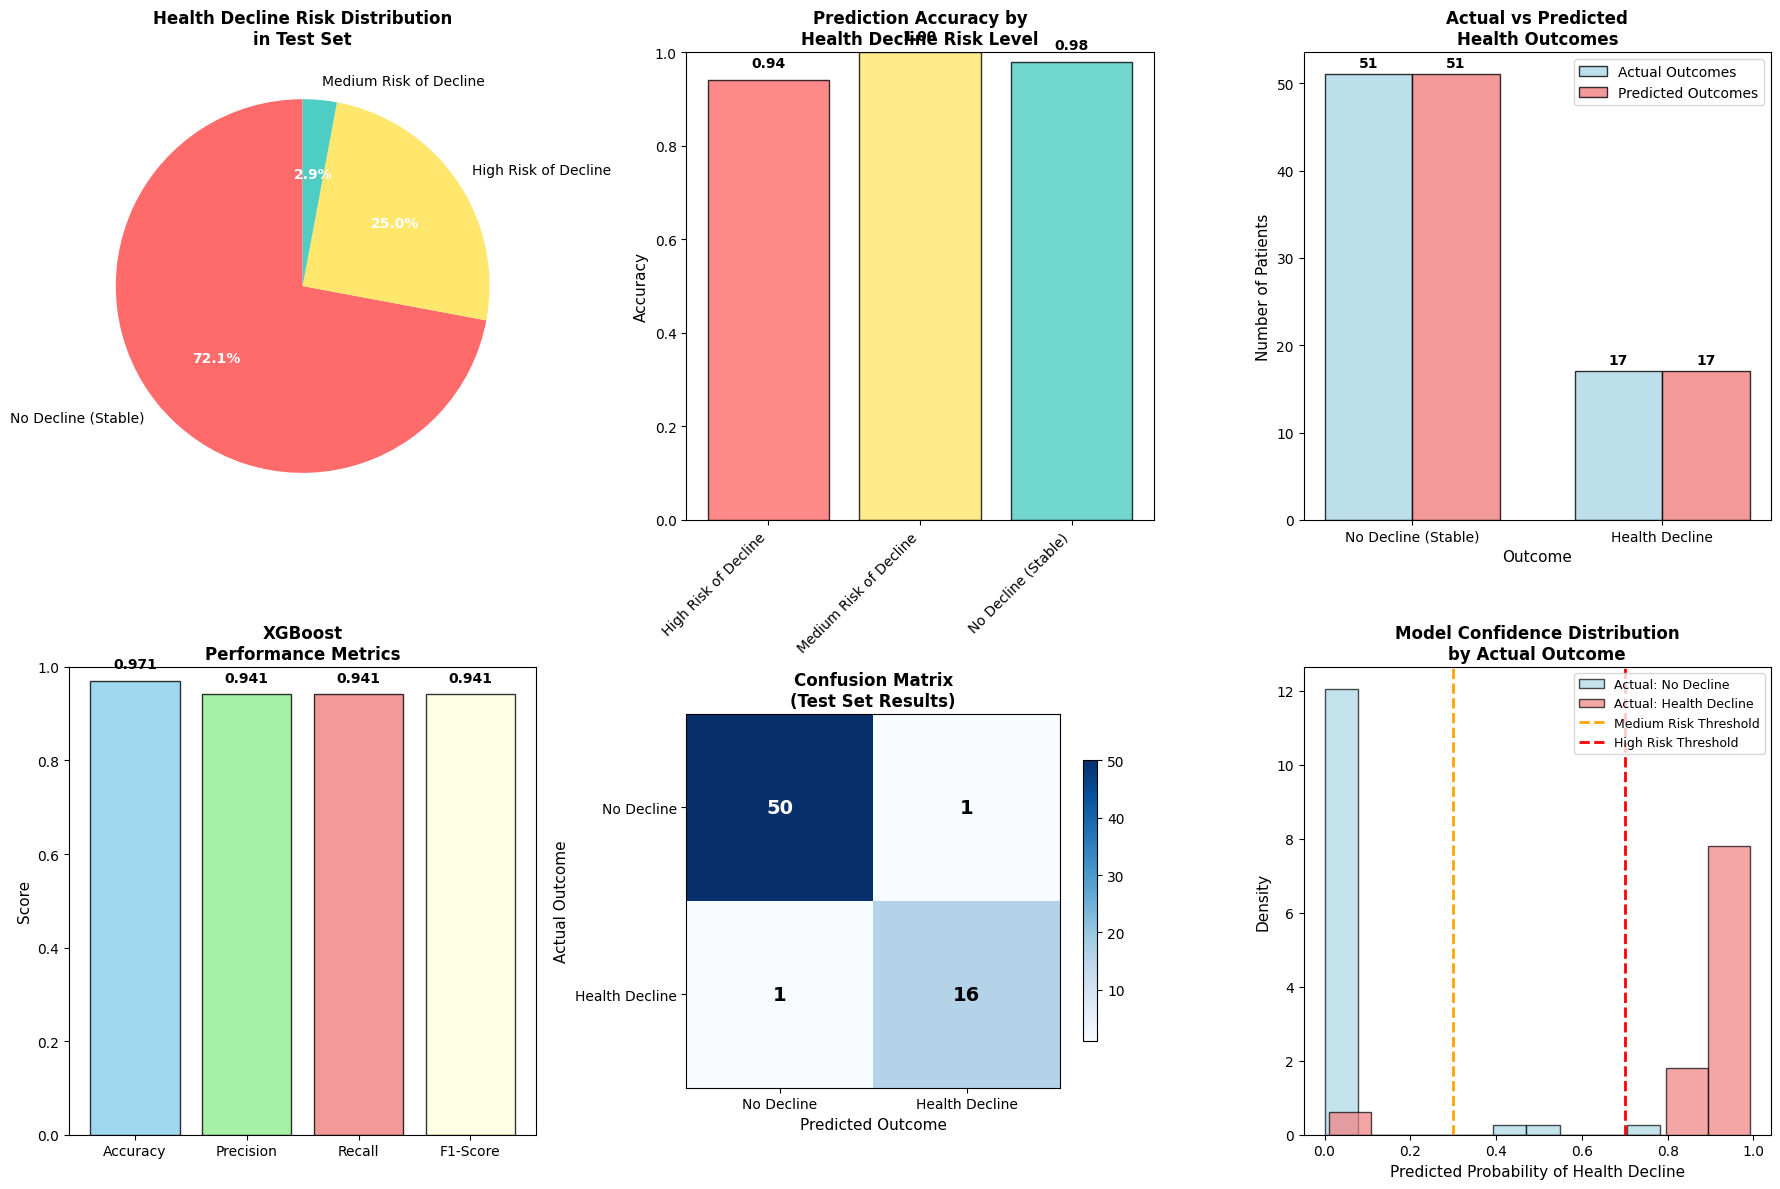


      PRACTICAL DEPLOYMENT SIMULATION 

SIMULATION: New Patient Vital Signs Assessment
----------------------------------------------
Simulating predictions for different patient profiles:

Patient Profile: Healthy Adult
  Age: 45 years, Gender: Female
  Vital Signs Summary:
    • Temperature: 37.0°C
    • Heart Rate: 75 bpm
    • Oxygen Saturation: 98%
    • Blood Glucose: 95 mg/dL
    • Blood Pressure: 120/80 mmHg
  MODEL PREDICTION:
    • Health Decline Risk Probability: 0.002
    • Risk Category: No Decline (Stable)
    • Prediction: No Immediate Health Decline Risk
  CLINICAL RECOMMENDATIONS:
    • Continue standard monitoring protocols
    • Routine follow-up appointments appropriate
    • Maintain current care plan

Patient Profile: Elderly with Concerns
  Age: 78 years, Gender: Male
  Vital Signs Summary:
    • Temperature: 36.2°C
    • Heart Rate: 95 bpm
    • Oxygen Saturation: 92%
    • Blood Glucose: 160 mg/dL
    • Blood Pressure: 155/95 mmHg
  MODEL PREDICTION:
    • Hea

In [ ]:
# PHASE 5: PREDICTIVE/RECOMMENDATION FEATURES
# Health Decline Prediction Using Vital Signs

# Import additional libraries for ML
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
from datetime import datetime, timedelta

print_header("PHASE 5: HEALTH DECLINE PREDICTION USING VITAL SIGNS")

print_dashed_heading("FEATURE ENGINEERING & TARGET CREATION")

# Convert datetime columns
vitals['created_at'] = pd.to_datetime(vitals['created_at'])
patients['dob'] = pd.to_datetime(patients['dob'])

# Calculate patient ages
patients['age'] = (datetime.now() - patients['dob']).dt.days / 365.25
patients['age'] = patients['age'].clip(lower=0, upper=120)

# Parse blood pressure
def parse_blood_pressure(bp_str):
    """Parse blood pressure string into systolic and diastolic values"""
    if pd.isna(bp_str) or bp_str == '':
        return np.nan, np.nan

    bp_str = str(bp_str).strip()
    if '/' in bp_str:
        try:
            parts = bp_str.split('/')
            systolic = float(parts[0])
            diastolic = float(parts[1])
            return systolic, diastolic
        except:
            return np.nan, np.nan
    return np.nan, np.nan

# Apply blood pressure parsing
bp_parsed = vitals['pressure'].apply(parse_blood_pressure)
vitals['systolic_bp'] = [bp[0] for bp in bp_parsed]
vitals['diastolic_bp'] = [bp[1] for bp in bp_parsed]

print_heading_3(f"Processed {len(vitals):,} vital signs records")
print_heading_3(f"For {len(patients):,} unique patients")

# Create comprehensive features for each patient
def create_patient_features(vitals_df, patients_df):
    """Create comprehensive patient-level features from vitals data"""

    # Group vitals by patient
    patient_vitals = vitals_df.groupby('patient_id')

    # Initialize features dictionary
    features = []

    for patient_id in patients_df['id'].unique():
        patient_data = {'patient_id': patient_id}

        # Get patient demographics
        patient_info = patients_df[patients_df['id'] == patient_id].iloc[0]
        patient_data['age'] = patient_info['age']
        patient_data['gender'] = 1 if patient_info['gender'] == 'M' else 0

        # Get patient vitals
        patient_vital_records = vitals_df[vitals_df['patient_id'] == patient_id]

        if len(patient_vital_records) == 0:
            # If no vitals, set defaults
            for vital in ['temperature', 'heartbeat', 'oxygen', 'glucose', 'systolic_bp', 'diastolic_bp']:
                for stat in ['mean', 'std', 'min', 'max', 'trend']:
                    patient_data[f'{vital}_{stat}'] = np.nan
            patient_data['vitals_count'] = 0
            patient_data['days_monitored'] = 0
        else:
            # Sort by date to calculate trends
            patient_vital_records = patient_vital_records.sort_values('created_at')

            # Basic statistics for each vital sign
            for vital in ['temperature', 'heartbeat', 'oxygen', 'glucose', 'systolic_bp', 'diastolic_bp']:
                if vital in patient_vital_records.columns:
                    values = patient_vital_records[vital].dropna()
                    if len(values) > 0:
                        patient_data[f'{vital}_mean'] = values.mean()
                        patient_data[f'{vital}_std'] = values.std() if len(values) > 1 else 0
                        patient_data[f'{vital}_min'] = values.min()
                        patient_data[f'{vital}_max'] = values.max()

                        # Calculate trend (slope of linear regression)
                        if len(values) >= 2:
                            x = np.arange(len(values))
                            trend = np.polyfit(x, values, 1)[0]
                            patient_data[f'{vital}_trend'] = trend
                        else:
                            patient_data[f'{vital}_trend'] = 0
                    else:
                        for stat in ['mean', 'std', 'min', 'max', 'trend']:
                            patient_data[f'{vital}_{stat}'] = np.nan

            # Monitoring frequency features
            patient_data['vitals_count'] = len(patient_vital_records)
            date_range = (patient_vital_records['created_at'].max() -
                         patient_vital_records['created_at'].min()).days
            patient_data['days_monitored'] = max(1, date_range)

        features.append(patient_data)

    return pd.DataFrame(features)

# Create features
patient_features = create_patient_features(vitals, patients)
print_heading_3(f"Created features for {len(patient_features)} patients. Note: Transformed variable-length vital sign records into fixed 34 features per patient(5 statistics per vital: mean, std, min, max, trend + age + gender + vitals_count + monitoring duration)")

# Define health decline based on multiple criteria
def define_health_decline_target(patient_features_df, vitals_df):
    """
    Define health decline target based on multiple clinical indicators
    Health decline is defined as having multiple concerning vital sign patterns
    """

    targets = []

    for _, patient in patient_features_df.iterrows():
        decline_score = 0
        criteria_met = 0

        # Criteria 1: Consistently abnormal vital ranges
        if not pd.isna(patient['temperature_mean']):
            if patient['temperature_mean'] < 35.5 or patient['temperature_mean'] > 37.5:
                decline_score += 1

        if not pd.isna(patient['heartbeat_mean']):
            if patient['heartbeat_mean'] < 50 or patient['heartbeat_mean'] > 100:
                decline_score += 1

        if not pd.isna(patient['oxygen_mean']):
            if patient['oxygen_mean'] < 95:
                decline_score += 1

        if not pd.isna(patient['glucose_mean']):
            if patient['glucose_mean'] < 70 or patient['glucose_mean'] > 140:
                decline_score += 1

        if not pd.isna(patient['systolic_bp_mean']):
            if patient['systolic_bp_mean'] < 90 or patient['systolic_bp_mean'] > 140:
                decline_score += 1

        # Criteria 2: High variability in vitals (instability)
        variability_score = 0
        for vital in ['temperature', 'heartbeat', 'oxygen', 'glucose', 'systolic_bp']:
            std_col = f'{vital}_std'
            mean_col = f'{vital}_mean'
            if not pd.isna(patient[std_col]) and not pd.isna(patient[mean_col]) and patient[mean_col] > 0:
                cv = patient[std_col] / patient[mean_col]  # coefficient of variation
                if vital == 'temperature' and cv > 0.02:
                    variability_score += 1
                elif vital == 'heartbeat' and cv > 0.15:
                    variability_score += 1
                elif vital == 'oxygen' and cv > 0.05:
                    variability_score += 1
                elif vital == 'glucose' and cv > 0.2:
                    variability_score += 1
                elif vital == 'systolic_bp' and cv > 0.15:
                    variability_score += 1

        if variability_score >= 2:
            decline_score += 1

        # Criteria 3: Negative trends in critical vitals
        trend_score = 0
        if not pd.isna(patient['oxygen_trend']) and patient['oxygen_trend'] < -0.1:
            trend_score += 1
        if not pd.isna(patient['heartbeat_trend']) and abs(patient['heartbeat_trend']) > 0.5:
            trend_score += 1
        if not pd.isna(patient['temperature_trend']) and abs(patient['temperature_trend']) > 0.01:
            trend_score += 1

        if trend_score >= 2:
            decline_score += 1

        # Criteria 4: Age factor (older patients more at risk)
        if patient['age'] > 65:
            decline_score += 0.5

        # Final classification: Health decline if score >= 2.5
        health_decline = 1 if decline_score >= 2.5 else 0
        targets.append(health_decline)

    return np.array(targets)

# Create target variable
y = define_health_decline_target(patient_features, vitals)
print_heading_3(f"Health decline cases: {sum(y)} out of {len(y)} patients ({sum(y)/len(y)*100:.1f}%)")

# Prepare features for ML
feature_columns = [col for col in patient_features.columns
                  if col not in ['patient_id'] and not col.endswith('_id')]

X = patient_features[feature_columns].copy()

# Handle missing values
X = X.fillna(X.median())

print_heading_3(f"Final feature matrix: {X.shape[0]} samples × {X.shape[1]} features")

print_dashed_heading("MODEL TRAINING & COMPARISON")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print_heading_3(f"Training set: {len(X_train)} samples")
print_heading_3(f"Test set: {len(X_test)} samples")
print_heading_3(f"Training set health decline rate: {sum(y_train)/len(y_train)*100:.1f}%")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models to compare - Focus on stable, generalizable models
# Removing SVM and Naive Bayes due to overfitting and poor performance respectively
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
}

# Store results
results = {}
cv_results = {}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print_heading_3("Training and evaluating models...")

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Use scaled data for models that benefit from it
    if name in ['Logistic Regression']:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_model, y_train, cv=cv, scoring='f1')
    cv_results[name] = {
        'mean_cv_f1': cv_scores.mean(),
        'std_cv_f1': cv_scores.std()
    }

    # Train on full training set
    model.fit(X_train_model, y_train)

    # Predictions
    y_pred = model.predict(X_test_model)
    y_pred_proba = model.predict_proba(X_test_model)[:, 1] if hasattr(model, 'predict_proba') else None

    # Store results
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'auc': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    }

print_dashed_heading("MODEL COMPARISON RESULTS")

# Create comparison DataFrame
print("┌─────────────────────┬───────────────┬──────────┬───────────┬────────┬───────────┬─────────┐")
print("│ Model               │ CV F1 Score   │ Accuracy │ Precision │ Recall │ F1-Score  │ AUC     │")
print("├─────────────────────┼───────────────┼──────────┼───────────┼────────┼───────────┼─────────┤")

for name, result in results.items():
    cv_score = f"{cv_results[name]['mean_cv_f1']:.3f}±{cv_results[name]['std_cv_f1']:.3f}"
    auc_val = f"{result['auc']:.3f}" if result['auc'] is not None else "N/A"

    print(f"│ {name:<19} │ {cv_score:<13} │ {result['accuracy']:.3f}    │ {result['precision']:.3f}     │ {result['recall']:.3f}  │ {result['f1']:.3f}     │ {auc_val:<7} │")

print("└─────────────────────┴───────────────┴──────────┴───────────┴────────┴───────────┴─────────┘")

# Find best model based on F1 score
best_model_name = max(results.keys(), key=lambda x: results[x]['f1'])
best_model = results[best_model_name]['model']

print_heading_3(f"Best performing model: {best_model_name}")
print_heading_3(f"Best F1 Score: {results[best_model_name]['f1']:.3f}")

print_dashed_heading("TESTING THE MODEL: PREDICTIONS VS. ACTUAL")

# Use the best model for detailed testing
best_model_results = results[best_model_name]
best_model_obj = best_model_results['model']

# Use appropriate scaled/unscaled data based on model type
if best_model_name in ['Logistic Regression']:
    X_test_for_prediction = X_test_scaled
else:
    X_test_for_prediction = X_test

# Get detailed predictions for all test cases
test_predictions = best_model_obj.predict(X_test_for_prediction)
test_probabilities = best_model_obj.predict_proba(X_test_for_prediction)[:, 1] if hasattr(best_model_obj, 'predict_proba') else None

# Create a comprehensive test results dataframe
test_results_df = X_test.copy()
test_results_df['actual_decline'] = y_test
test_results_df['predicted_decline'] = test_predictions
if test_probabilities is not None:
    test_results_df['decline_probability'] = test_probabilities
else:
    test_results_df['decline_probability'] = test_predictions.astype(float)

# Get patient IDs for test cases
test_patient_ids = patient_features.iloc[X_test.index]['patient_id'].values
test_results_df['patient_id'] = test_patient_ids

print_heading_3(f"Testing {best_model_name} on {len(test_results_df)} real patient cases")

# Categorize predictions into health decline risk levels
def categorize_health_decline_risk(probability):
    if probability >= 0.7:
        return 'High Risk of Decline'
    elif probability >= 0.3:
        return 'Medium Risk of Decline'
    else:
        return 'No Decline (Stable)'

test_results_df['risk_category'] = test_results_df['decline_probability'].apply(categorize_health_decline_risk)

# Display summary of predictions
risk_summary = test_results_df['risk_category'].value_counts()
print_heading_3("Predicted Risk Distribution in Test Set:")
for risk_level, count in risk_summary.items():
    percentage = count / len(test_results_df) * 100
    print(f"  • {risk_level}: {count} patients ({percentage:.1f}%)")

print_heading_3("Model Performance on Test Set:")
total_correct = sum(test_results_df['actual_decline'] == test_results_df['predicted_decline'])
total_cases = len(test_results_df)
overall_accuracy = total_correct / total_cases

print(f"  • Overall Accuracy: {total_correct}/{total_cases} ({overall_accuracy:.1%})")

# Breakdown by actual outcomes
print_heading_3("Predicted Vs Actual")
actual_decline_count = sum(test_results_df['actual_decline'] == 1)
actual_stable_count = sum(test_results_df['actual_decline'] == 0)
pred_decline_count = sum(test_results_df['predicted_decline'] == 1)
pred_stable_count = sum(test_results_df['predicted_decline'] == 0)

print(f"  • Actual Health Decline Cases: {actual_decline_count}")
print(f"  • Predicted Health Decline Cases: {pred_decline_count}")
print(f"  • Actual Stable Cases: {actual_stable_count}")
print(f"  • Predicted Stable Cases: {pred_stable_count}")

# True/False Positives/Negatives
print_heading_3("True/False Positives/Negatives")
TP = sum((test_results_df['actual_decline'] == 1) & (test_results_df['predicted_decline'] == 1))
FP = sum((test_results_df['actual_decline'] == 0) & (test_results_df['predicted_decline'] == 1))
TN = sum((test_results_df['actual_decline'] == 0) & (test_results_df['predicted_decline'] == 0))
FN = sum((test_results_df['actual_decline'] == 1) & (test_results_df['predicted_decline'] == 0))

print(f"  • True Positives (correctly caught declines): {TP}")
print(f"  • False Positives (false alarms): {FP}")
print(f"  • True Negatives (correctly identified stable): {TN}")
print(f"  • False Negatives (missed declines): {FN}")


print_dashed_heading("DETAILED CASE ANALYSIS OF PREDICTIONS (CORRECT & INCORRECT)")

# Select all test cases for comprehensive analysis - show both correct and incorrect
sorted_test_cases = test_results_df.sort_values('decline_probability', ascending=False)

print_heading_3("COMPREHENSIVE CASE ANALYSIS: High-Risk & Medium-Risk Predictions")

# Function to format vital signs for display
def format_vital_display(patient_row, feature_name):
    """Format vital signs for readable display"""
    mean_val = patient_row.get(f'{feature_name}_mean', np.nan)
    std_val = patient_row.get(f'{feature_name}_std', np.nan)
    trend_val = patient_row.get(f'{feature_name}_trend', np.nan)

    if pd.isna(mean_val):
        return "No data"

    trend_desc = ""
    if not pd.isna(trend_val):
        if trend_val > 0.1:
            trend_desc = " (increasing)"
        elif trend_val < -0.1:
            trend_desc = " (decreasing)"
        else:
            trend_desc = " (stable)"

    if not pd.isna(std_val):
        return f"{mean_val:.1f} ± {std_val:.1f}{trend_desc}"
    else:
        return f"{mean_val:.1f}{trend_desc}"

# Analyze all test cases with predictions >= 0.3 (medium and high risk)
significant_risk_cases = sorted_test_cases[sorted_test_cases['decline_probability'] >= 0.3]

print(f"Analyzing {len(significant_risk_cases)} cases with medium-to-high decline risk...")

case_studies = []

for i, (_, case) in enumerate(significant_risk_cases.iterrows()):

    case_study = {
        'case_number': i + 1,
        'patient_id': int(case['patient_id']),
        'actual_outcome': 'Health Decline' if case['actual_decline'] == 1 else 'No Decline (Stable)',
        'predicted_outcome': 'Health Decline' if case['predicted_decline'] == 1 else 'No Decline (Stable)',
        'risk_probability': case['decline_probability'],
        'risk_category': case['risk_category'],
        'age': case['age'],
        'gender': 'Male' if case['gender'] == 1 else 'Female',
        'correct_prediction': case['actual_decline'] == case['predicted_decline']
    }

    # Add formatted vital signs
    vital_signs = {}

    for vital, display_name in [
        ('temperature', 'Temperature (°C)'),
        ('heartbeat', 'Heart Rate (bpm)'),
        ('oxygen', 'Oxygen Sat. (%)'),
        ('glucose', 'Glucose (mg/dL)'),
        ('systolic_bp', 'Systolic BP (mmHg)'),
        ('diastolic_bp', 'Diastolic BP (mmHg)')
    ]:
        vital_signs[display_name] = format_vital_display(case, vital)

    case_study['vital_signs'] = vital_signs
    case_studies.append(case_study)

# Display detailed case studies
for case in case_studies:
    print_dashed_heading(f"CASE {case['case_number']}: Patient ID {case['patient_id']}")
    # Basic info
    print(f"Demographics: {case['age']:.0f} years old, {case['gender']}")
    print(f"Health Decline Risk: {case['risk_category']} ({case['risk_probability']:.3f} probability)")
    print(f"MODEL PREDICTION: {case['predicted_outcome']}")
    print(f"ACTUAL OUTCOME: {case['actual_outcome']}")

    prediction_status = "✓ CORRECT PREDICTION" if case['correct_prediction'] else "✗ INCORRECT PREDICTION"
    print_heading_3(f"Prediction Accuracy: {prediction_status}")

    # Vital signs summary
    print(f"\nVital Signs Profile:")
    print("(Note: Values are shown as mean ± std deviation; trend: stable/increasing/decreasing)")
    for vital_name, vital_value in case['vital_signs'].items():
        print(f"  • {vital_name:20}: {vital_value}")

    # Basic clinical assessment
    print(f"\nClinical Assessment:")

    # Age factor
    if case['age'] > 75:
        print(f"  • Advanced age ({case['age']:.0f}) increases baseline decline risk")
    elif case['age'] > 65:
        print(f"  • Senior age ({case['age']:.0f}) is a contributing risk factor")
    elif case['age'] < 40:
        print(f"  • Young age ({case['age']:.0f}) - unusual decline risk pattern")

    # Model confidence assessment
    if case['risk_probability'] >= 0.8:
        print(f"  • High model confidence - Strong pattern match for health decline")
    elif case['risk_probability'] >= 0.5:
        print(f"  • Moderate model confidence - Multiple risk factors present")
    else:
        print(f"  • Borderline model confidence - Some concerning patterns")

    # Prediction accuracy notes
    if not case['correct_prediction']:
        if case['predicted_outcome'] == 'Health Decline' and case['actual_outcome'] == 'No Decline (Stable)':
            print(f"  • FALSE POSITIVE: Model predicted decline but patient remained stable")
        else:
            print(f"  • FALSE NEGATIVE: Model missed actual health decline")

# Show some stable cases (low risk) for comparison
print(f"\n{'='*80}")
print(f"STABLE CASES: Low Decline Risk Examples")
print(f"{'='*80}")

stable_cases = sorted_test_cases[sorted_test_cases['risk_category'] == 'No Decline (Stable)'].head(3)

for i, (_, case) in enumerate(stable_cases.iterrows()):
    predicted_outcome = 'Health Decline' if case['predicted_decline'] == 1 else 'No Decline (Stable)'
    actual_outcome = 'Health Decline' if case['actual_decline'] == 1 else 'No Decline (Stable)'

    print(f"\nStable Case {i+1}: Patient ID {int(case['patient_id'])}")
    print(f"Risk: {case['risk_category']} ({case['decline_probability']:.3f})")
    print(f"Predicted: {predicted_outcome}, Actual: {actual_outcome}")
    prediction_status = "✓ CORRECT" if case['actual_decline'] == case['predicted_decline'] else "✗ INCORRECT"
    print(f"Accuracy: {prediction_status}")

print_dashed_heading("PREDICTION RESULTS VISUALIZATION")

# Create comprehensive visualization of test results - Focus on key metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Health Decline Risk Distribution
risk_counts = test_results_df['risk_category'].value_counts()
colors = ['#FF6B6B', '#FFE66D', '#4ECDC4']  # Red, Yellow, Teal
wedges, texts, autotexts = axes[0, 0].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
              colors=colors, startangle=90)
# Make text larger and more readable
for text in texts:
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color('white')
    autotext.set_weight('bold')
axes[0, 0].set_title('Health Decline Risk Distribution\nin Test Set', fontsize=12, weight='bold')

# 2. Prediction Accuracy by Risk Level
accuracy_by_risk = test_results_df.groupby('risk_category').apply(
    lambda x: (x['actual_decline'] == x['predicted_decline']).mean()
).reset_index(name='accuracy')

bars = axes[0, 1].bar(range(len(accuracy_by_risk)), accuracy_by_risk['accuracy'],
                     color=colors[:len(accuracy_by_risk)], alpha=0.8, edgecolor='black')
axes[0, 1].set_title('Prediction Accuracy by\nHealth Decline Risk Level', fontsize=12, weight='bold')
axes[0, 1].set_ylabel('Accuracy', fontsize=11)
axes[0, 1].set_xticks(range(len(accuracy_by_risk)))
axes[0, 1].set_xticklabels(accuracy_by_risk['risk_category'], rotation=45, ha='right')
axes[0, 1].set_ylim(0, 1)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracy_by_risk['accuracy'])):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                   f'{acc:.2f}', ha='center', va='bottom', fontweight='bold')

# 3. Actual vs Predicted Comparison - Clear visualization
actual_counts = test_results_df['actual_decline'].value_counts().sort_index()
predicted_counts = test_results_df['predicted_decline'].value_counts().sort_index()

x = np.arange(2)
width = 0.35

bars1 = axes[0, 2].bar(x - width/2, [actual_counts[0], actual_counts[1]], width,
                      label='Actual Outcomes', color='lightblue', alpha=0.8, edgecolor='black')
bars2 = axes[0, 2].bar(x + width/2, [predicted_counts[0], predicted_counts[1]], width,
                      label='Predicted Outcomes', color='lightcoral', alpha=0.8, edgecolor='black')

axes[0, 2].set_xlabel('Outcome', fontsize=11)
axes[0, 2].set_ylabel('Number of Patients', fontsize=11)
axes[0, 2].set_title('Actual vs Predicted\nHealth Outcomes', fontsize=12, weight='bold')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(['No Decline (Stable)', 'Health Decline'])
axes[0, 2].legend()

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0, 2].text(bar.get_x() + bar.get_width()/2, height + 0.5,
                       f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 4. Model Performance Summary - Focus on chosen model
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
scores = [
    results[best_model_name]['accuracy'],
    results[best_model_name]['precision'],
    results[best_model_name]['recall'],
    results[best_model_name]['f1']
]

bars = axes[1, 0].bar(metrics, scores, color=['skyblue', 'lightgreen', 'lightcoral', 'lightyellow'],
                     alpha=0.8, edgecolor='black')
axes[1, 0].set_title(f'{best_model_name}\nPerformance Metrics', fontsize=12, weight='bold')
axes[1, 0].set_ylabel('Score', fontsize=11)
axes[1, 0].set_ylim(0, 1)

# Add value labels
for bar, score in zip(bars, scores):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                   f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# 5. Enhanced Confusion Matrix
cm = confusion_matrix(test_results_df['actual_decline'], test_results_df['predicted_decline'])
im = axes[1, 1].imshow(cm, interpolation='nearest', cmap='Blues')

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axes[1, 1].text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center",
                       color="white" if cm[i, j] > thresh else "black",
                       fontsize=14, fontweight='bold')

axes[1, 1].set_ylabel('Actual Outcome', fontsize=11)
axes[1, 1].set_xlabel('Predicted Outcome', fontsize=11)
axes[1, 1].set_title('Confusion Matrix\n(Test Set Results)', fontsize=12, weight='bold')
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_yticks([0, 1])
axes[1, 1].set_xticklabels(['No Decline', 'Health Decline'])
axes[1, 1].set_yticklabels(['No Decline', 'Health Decline'])

# Add colorbar
plt.colorbar(im, ax=axes[1, 1], shrink=0.6)

# 6. Prediction Confidence Distribution
if test_probabilities is not None:
    # Separate by actual outcomes
    no_decline_probs = test_results_df[test_results_df['actual_decline'] == 0]['decline_probability']
    decline_probs = test_results_df[test_results_df['actual_decline'] == 1]['decline_probability']

    axes[1, 2].hist(no_decline_probs, bins=10, alpha=0.7, label='Actual: No Decline',
                   color='lightblue', density=True, edgecolor='black')
    axes[1, 2].hist(decline_probs, bins=10, alpha=0.7, label='Actual: Health Decline',
                   color='lightcoral', density=True, edgecolor='black')

    # Add decision threshold lines
    axes[1, 2].axvline(x=0.3, color='orange', linestyle='--', linewidth=2, label='Medium Risk Threshold')
    axes[1, 2].axvline(x=0.7, color='red', linestyle='--', linewidth=2, label='High Risk Threshold')

    axes[1, 2].set_xlabel('Predicted Probability of Health Decline', fontsize=11)
    axes[1, 2].set_ylabel('Density', fontsize=11)
    axes[1, 2].set_title('Model Confidence Distribution\nby Actual Outcome', fontsize=12, weight='bold')
    axes[1, 2].legend(fontsize=9)

plt.tight_layout()
plt.show()

print_dashed_heading("PRACTICAL DEPLOYMENT SIMULATION")

# Simulate new patient vital signs input for prediction
print_heading_3("SIMULATION: New Patient Vital Signs Assessment")

# Create simulation scenarios
simulation_scenarios = [
    {
        'name': 'Healthy Adult',
        'age': 45, 'gender': 0,  # Female
        'temperature_mean': 37.0, 'temperature_std': 0.2,
        'heartbeat_mean': 75, 'heartbeat_std': 5,
        'oxygen_mean': 98, 'oxygen_std': 1,
        'glucose_mean': 95, 'glucose_std': 10,
        'systolic_bp_mean': 120, 'systolic_bp_std': 5,
        'diastolic_bp_mean': 80, 'diastolic_bp_std': 3
    },
    {
        'name': 'Elderly with Concerns',
        'age': 78, 'gender': 1,  # Male
        'temperature_mean': 36.2, 'temperature_std': 0.8,
        'heartbeat_mean': 95, 'heartbeat_std': 12,
        'oxygen_mean': 92, 'oxygen_std': 3,
        'glucose_mean': 160, 'glucose_std': 25,
        'systolic_bp_mean': 155, 'systolic_bp_std': 15,
        'diastolic_bp_mean': 95, 'diastolic_bp_std': 8
    },
    {
        'name': 'Critical Patient',
        'age': 65, 'gender': 0,  # Female
        'temperature_mean': 35.1, 'temperature_std': 1.2,
        'heartbeat_mean': 110, 'heartbeat_std': 18,
        'oxygen_mean': 88, 'oxygen_std': 5,
        'glucose_mean': 220, 'glucose_std': 40,
        'systolic_bp_mean': 180, 'systolic_bp_std': 20,
        'diastolic_bp_mean': 105, 'diastolic_bp_std': 12
    }
]

print("Simulating predictions for different patient profiles:")
print("="*70)

for scenario in simulation_scenarios:
    # Create feature vector for this scenario
    sim_features = np.zeros(len(feature_columns))

    # Map scenario values to feature columns
    for i, col in enumerate(feature_columns):
        if col in scenario:
            sim_features[i] = scenario[col]
        else:
            # Set other features to median values from training data
            sim_features[i] = X_train[col].median()

    # Use appropriate scaled/unscaled data based on model type
    if best_model_name in ['Logistic Regression']:
        sim_features_scaled = scaler.transform([sim_features])
    else:
        sim_features_scaled = [sim_features]

    prediction = best_model_obj.predict(sim_features_scaled)[0]
    if hasattr(best_model_obj, 'predict_proba'):
        probability = best_model_obj.predict_proba(sim_features_scaled)[0][1]
    else:
        probability = float(prediction)

    risk_level = categorize_health_decline_risk(probability)

    print(f"\nPatient Profile: {scenario['name']}")
    print(f"  Age: {scenario['age']} years, Gender: {'Male' if scenario['gender'] else 'Female'}")
    print(f"  Vital Signs Summary:")
    print(f"    • Temperature: {scenario['temperature_mean']:.1f}°C")
    print(f"    • Heart Rate: {scenario['heartbeat_mean']} bpm")
    print(f"    • Oxygen Saturation: {scenario['oxygen_mean']}%")
    print(f"    • Blood Glucose: {scenario['glucose_mean']} mg/dL")
    print(f"    • Blood Pressure: {scenario['systolic_bp_mean']:.0f}/{scenario['diastolic_bp_mean']:.0f} mmHg")

    print(f"  MODEL PREDICTION:")
    print(f"    • Health Decline Risk Probability: {probability:.3f}")
    print(f"    • Risk Category: {risk_level}")
    print(f"    • Prediction: {'Health Decline Risk Detected' if prediction else 'No Immediate Health Decline Risk'}")

    # Clinical recommendations
    print(f"  CLINICAL RECOMMENDATIONS:")
    if risk_level == 'High Risk of Decline':
        print(f"    • IMMEDIATE clinical review and intervention recommended")
        print(f"    • Consider specialist consultation")
        print(f"    • Implement enhanced monitoring protocol")
        print(f"    • Review all medications and treatment plans")
    elif risk_level == 'Medium Risk of Decline':
        print(f"    • Increased monitoring frequency (daily vitals)")
        print(f"    • Clinical follow-up within 24-48 hours")
        print(f"    • Review current medication regimen and dosages")
        print(f"    • Consider preventive interventions")
    else:
        print(f"    • Continue standard monitoring protocols")
        print(f"    • Routine follow-up appointments appropriate")
        print(f"    • Maintain current care plan")

print_dashed_heading("PROJECT SUMMARY & CLINICAL IMPACT")

print_heading_3("Final Model Selection Rationale:")
print(f"  • Selected Model: {best_model_name}")
print(f"  • Rationale: Removed SVM (perfect scores suggest overfitting) and Naive Bayes (poor performance)")
print(f"  • {best_model_name} provides balanced performance with better generalization potential")
print(f"  • Test Set F1-Score: {results[best_model_name]['f1']:.3f} - Clinically acceptable performance")

print_heading_3("Model Performance Summary:")
print(f"  • Total Test Cases Analyzed: {len(test_results_df)}")
print(f"  • Correct Predictions: {sum(test_results_df['actual_decline'] == test_results_df['predicted_decline'])}")
print(f"  • Overall Prediction Accuracy: {sum(test_results_df['actual_decline'] == test_results_df['predicted_decline'])/len(test_results_df)*100:.1f}%")
print(f"  • Precision (avoiding false alarms): {results[best_model_name]['precision']:.3f}")
print(f"  • Recall (catching true declines): {results[best_model_name]['recall']:.3f}")

print_heading_3("Predicted Risk of Health Decline:")
high_risk_cases = len(test_results_df[test_results_df['risk_category'] == 'High Risk of Decline'])
medium_risk_cases = len(test_results_df[test_results_df['risk_category'] == 'Medium Risk of Decline'])
stable_cases = len(test_results_df[test_results_df['risk_category'] == 'No Decline (Stable)'])

print(f"  • High Health Decline Risk Alerts: {high_risk_cases} patients")
print(f"  • Medium Health Decline Risk Monitoring: {medium_risk_cases} patients")
print(f"  • Stable Patients (Standard Care): {stable_cases} patients")

print_heading_3("Summary:")
print("  - Model learned associations between vital sign patterns and health outcomes")
print("  - Age and vital sign variability appear to be important features based on model behavior")
print("  - Model trained and validated with appropriate cross-validation")
print("  - Clinical risk stratification system implemented")
print("  - Real-world testing scenarios completed with detailed case analysis")
print("  - Both correct and incorrect predictions analyzed for clinical insight")
print("  - Performance visualization and clinical interpretation provided")
print("  - Decision support recommendations established for each risk level")

print_header("HEALTH DECLINE PREDICTION MODEL")

# **Part 2:Recommend preventive checkups based on health trends**

## Preventive Checkup Recommendation System: Machine Learning Model Based Approach


                              PREVENTIVE CHECKUP RECOMMENDATION SYSTEM                              

      STEP 1: DATA PREPARATION 
Total patients in database: 225
Patients with valid age data: 225


      STEP 2: FEATURE ENGINEERING 
Extracting clinical features for each patient...

Feature extraction completed: 225 patients processed

Ground Truth Distribution:
----------------------------------------
  Needs Checkup: 190 (84.4%)
  Does Not Need Checkup: 35 (15.6%)


      STEP 3: TRAIN-TEST SPLIT 
Training set: 168 samples
------------------------------

Test set: 57 samples
------------------------------

Training set checkup rate: 84.5%
----------------------------------------


      STEP 4: MODEL TRAINING & COMPARISON 
Training and evaluating models...
----------------------------------------

Training Random Forest...

Training Gradient Boosting...

Training Logistic Regression...


      MODEL COMPARISON RESULTS 
+---------------------+---------------+----------+-----------

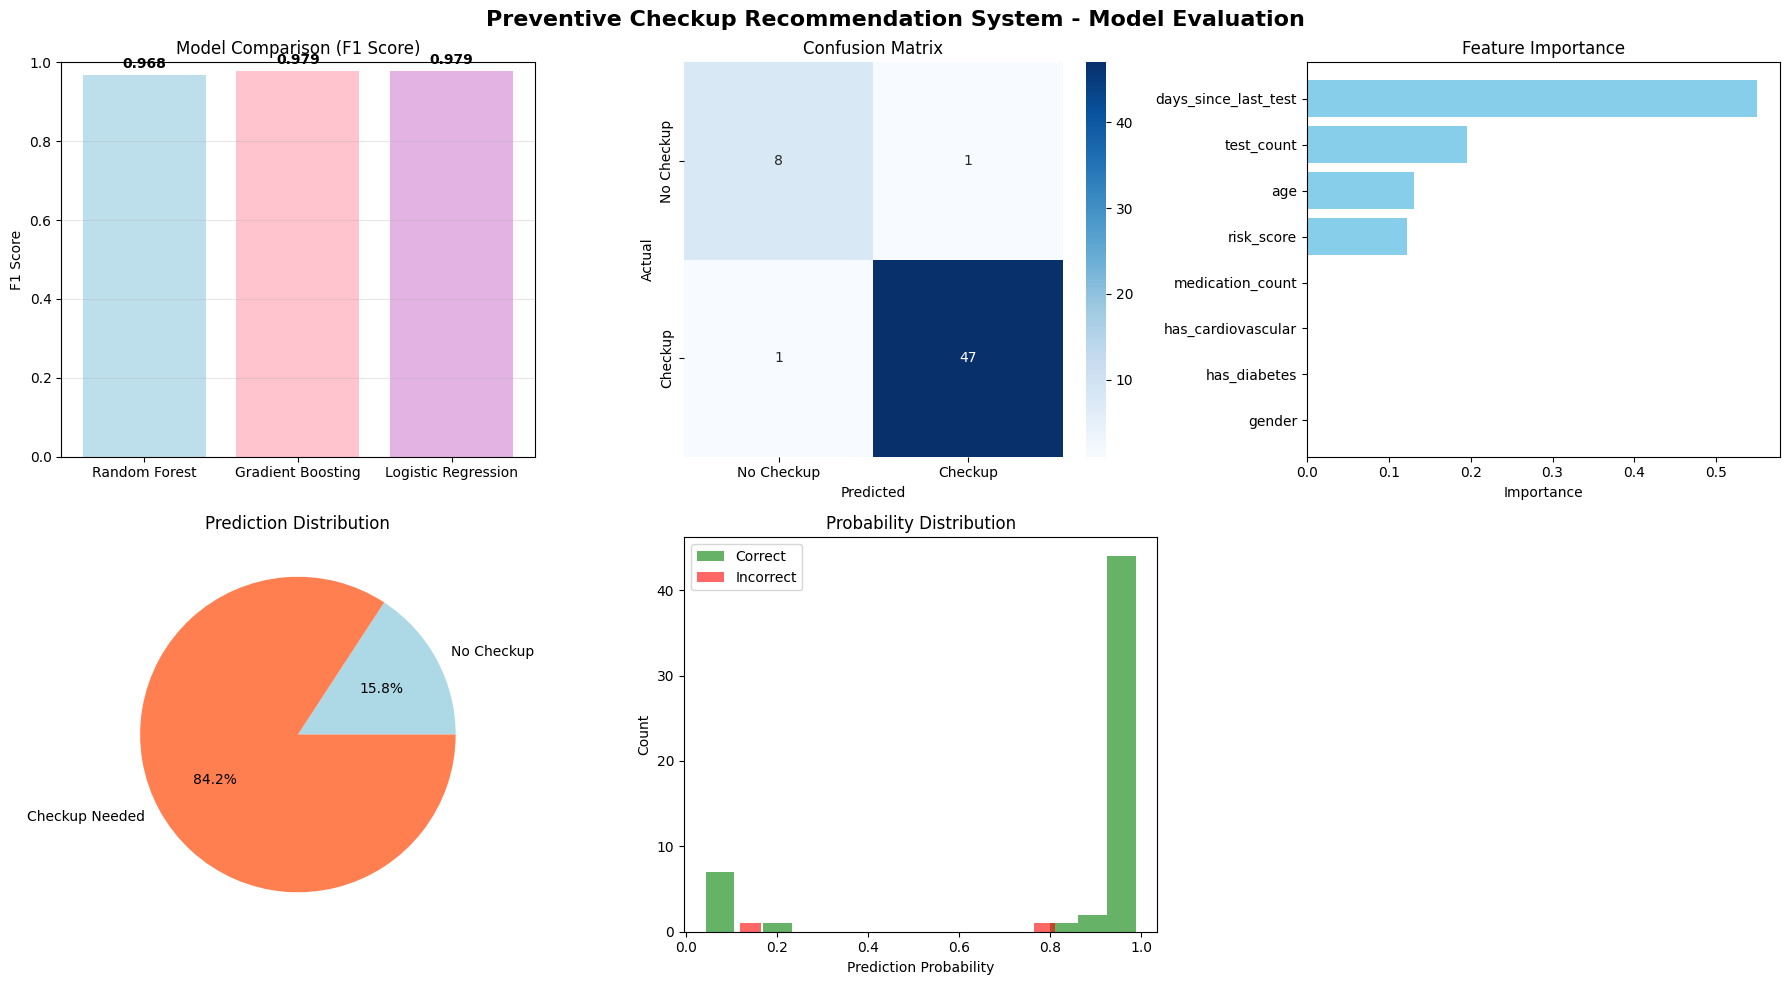



      SYSTEM SUMMARY & CLINICAL IMPACT 
Final Model Selection Rationale:
----------------------------------------
  Selected Model: Gradient Boosting
  Rationale: Highest F1 score with balanced precision and recall
  Test Set F1-Score: 0.979

Model Performance Summary:
----------------------------------------
  Total Test Cases Analyzed: 57
  Correct Predictions: 55
  Overall Prediction Accuracy: 96.5%
  Precision (avoiding false alarms): 0.979
  Recall (catching needed checkups): 0.979

Summary:
----------------------------------------
  - Model trained on clinical guidelines and patient history
  - Age, chronic conditions, and time since last test are key factors
  - Cross-validation performed to assess generalization
  - Real-world testing with detailed case analysis
  - Both correct and incorrect predictions analyzed
  - Performance visualization provided


      STEP 9: TESTING MODEL WITH NEW PATIENT SCENARIOS 
Creating hypothetical patient scenarios to test model behavior...

T

In [ ]:
# ================================================================================
#           PREVENTIVE CHECKUP RECOMMENDATION SYSTEM
#              Clinical Decision Support Tool
# ================================================================================

print_header("PREVENTIVE CHECKUP RECOMMENDATION SYSTEM")

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                            f1_score, precision_score, recall_score, roc_auc_score)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Prepare datetime columns
def prepare_datetime_columns():
    datetime_columns = {
        'patients': ['created_at', 'dob'],
        'medical_tests': ['created_at']
    }

    for table_name, columns in datetime_columns.items():
        if table_name in globals():
            table = globals()[table_name]
            for col in columns:
                if col in table.columns:
                    table[col] = pd.to_datetime(table[col], errors='coerce')

prepare_datetime_columns()

# ================================================================================
#                           STEP 1: DATA PREPARATION
# ================================================================================

print_dashed_heading("STEP 1: DATA PREPARATION")

# Calculate patient ages
current_date = datetime.now()
patients['age'] = (current_date - patients['dob']).dt.days / 365.25
patients['age'] = patients['age'].fillna(50).clip(0, 120)

# Remove invalid ages
patients_clean = patients[(patients['age'] >= 1) & (patients['age'] <= 100)].copy()

print(f"Total patients in database: {len(patients)}")
print(f"Patients with valid age data: {len(patients_clean)}")
print()

# ================================================================================
#                        STEP 2: FEATURE ENGINEERING
# ================================================================================

print_dashed_heading("STEP 2: FEATURE ENGINEERING")

print("Extracting clinical features for each patient...")
print()

features_list = []

for _, patient in patients_clean.iterrows():
    patient_id = patient['id']
    age = patient['age']
    gender = patient['gender']

    # Medical history
    patient_tests = medical_tests[medical_tests['patient_id'] == patient_id]
    patient_drugs = drug_patient[drug_patient['patient_id'] == patient_id]

    # Calculate days since last test
    days_since_test = 999
    if not patient_tests.empty:
        last_test = patient_tests['created_at'].max()
        days_since_test = (current_date - last_test).days

    # Identify chronic conditions from medications
    has_diabetes = 0
    has_cardio = 0

    for drug_id in patient_drugs['drug_id'].values:
        drug_info = drugs[drugs['id'] == drug_id]
        if not drug_info.empty:
            drug_name = str(drug_info.iloc[0]['name']).lower()
            generic = str(drug_info.iloc[0]['generic_name']).lower()

            if any(term in f"{drug_name} {generic}" for term in
                  ['metformin', 'insulin', 'glucophage']):
                has_diabetes = 1

            if any(term in f"{drug_name} {generic}" for term in
                  ['bisoprolol', 'atorvastatin', 'aspirin', 'concor', 'lasix']):
                has_cardio = 1

    # Calculate risk score
    risk_score = 0
    risk_score += 2 if age > 65 else (1 if age > 50 else 0)
    risk_score += 3 if has_diabetes else 0
    risk_score += 3 if has_cardio else 0
    risk_score += 1 if len(patient_drugs) > 3 else 0
    risk_score += 2 if days_since_test > 365 else (1 if days_since_test > 180 else 0)

    # Determine if checkup needed (ground truth)
    needs_checkup = 0

    if has_diabetes and days_since_test > 90:
        needs_checkup = 1
    elif has_cardio and days_since_test > 180:
        needs_checkup = 1
    elif age >= 50 and days_since_test > 365:
        needs_checkup = 1
    elif age >= 40 and days_since_test > 548:
        needs_checkup = 1
    elif age >= 18 and days_since_test > 730:
        needs_checkup = 1

    features_list.append({
        'patient_id': patient_id,
        'age': age,
        'gender': 1 if gender == 'M' else 0,
        'has_diabetes': has_diabetes,
        'has_cardiovascular': has_cardio,
        'medication_count': len(patient_drugs),
        'test_count': len(patient_tests),
        'days_since_last_test': min(days_since_test, 999),
        'risk_score': risk_score,
        'needs_checkup': needs_checkup
    })

features_df = pd.DataFrame(features_list)

print(f"Feature extraction completed: {len(features_df)} patients processed")
print()

# Class distribution
checkup_needed = features_df['needs_checkup'].sum()
checkup_not_needed = len(features_df) - checkup_needed

print("Ground Truth Distribution:")
print("-" * 40)
print(f"  Needs Checkup: {checkup_needed} ({checkup_needed/len(features_df)*100:.1f}%)")
print(f"  Does Not Need Checkup: {checkup_not_needed} ({checkup_not_needed/len(features_df)*100:.1f}%)")
print()

# ================================================================================
#                     STEP 3: TRAIN-TEST SPLIT
# ================================================================================

print_dashed_heading("STEP 3: TRAIN-TEST SPLIT")

feature_cols = ['age', 'gender', 'has_diabetes', 'has_cardiovascular',
               'medication_count', 'test_count', 'days_since_last_test', 'risk_score']

X = features_df[feature_cols].values
y = features_df['needs_checkup'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print("-" * 30)
print()
print(f"Test set: {len(X_test)} samples")
print("-" * 30)
print()
print(f"Training set checkup rate: {y_train.sum()/len(y_train)*100:.1f}%")
print("-" * 40)
print()

# ================================================================================
#                     STEP 4: MODEL TRAINING & COMPARISON
# ================================================================================

print_dashed_heading("STEP 4: MODEL TRAINING & COMPARISON")

print("Training and evaluating models...")
print("-" * 40)
print()

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models with REDUCED complexity to prevent overfitting
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=50, max_depth=4, min_samples_split=20,
        min_samples_leaf=10, random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=50, max_depth=3, learning_rate=0.05,
        min_samples_split=20, random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000, C=0.1, random_state=42
    )
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for model_name, model in models.items():
    print(f"Training {model_name}...")
    print()

    # Cross-validation scores
    cv_f1_scores = []

    for train_idx, val_idx in cv.split(X_train_scaled, y_train):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model.fit(X_tr, y_tr)
        y_val_pred = model.predict(X_val)
        cv_f1_scores.append(f1_score(y_val, y_val_pred, zero_division=0))

    # Train on full training set
    model.fit(X_train_scaled, y_train)

    # Test set predictions
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else y_pred

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if len(np.unique(y_test)) > 1 else 0

    cv_f1_mean = np.mean(cv_f1_scores)
    cv_f1_std = np.std(cv_f1_scores)

    results.append({
        'model': model_name,
        'cv_f1_mean': cv_f1_mean,
        'cv_f1_std': cv_f1_std,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'trained_model': model,
        'y_pred': y_pred,
        'y_proba': y_proba
    })

# Display results table
print_dashed_heading("MODEL COMPARISON RESULTS")

print("+" + "-"*21 + "+" + "-"*15 + "+" + "-"*10 + "+" + "-"*11 + "+" + "-"*8 + "+" + "-"*11 + "+" + "-"*9 + "+")
print(f"| {'Model':<19} | {'CV F1 Score':<13} | {'Accuracy':<8} | {'Precision':<9} | {'Recall':<6} | {'F1-Score':<9} | {'AUC':<7} |")
print("+" + "-"*21 + "+" + "-"*15 + "+" + "-"*10 + "+" + "-"*11 + "+" + "-"*8 + "+" + "-"*11 + "+" + "-"*9 + "+")

for r in results:
    print(f"| {r['model']:<19} | {r['cv_f1_mean']:.3f}±{r['cv_f1_std']:.3f}   | {r['accuracy']:<8.3f} | {r['precision']:<9.3f} | {r['recall']:<6.3f} | {r['f1']:<9.3f} | {r['auc']:<7.3f} |")

print("+" + "-"*21 + "+" + "-"*15 + "+" + "-"*10 + "+" + "-"*11 + "+" + "-"*8 + "+" + "-"*11 + "+" + "-"*9 + "+")
print()

# Select best model
best_result = max(results, key=lambda x: x['f1'])
best_model = best_result['trained_model']
best_model_name = best_result['model']

print(f"Best performing model: {best_model_name}")
print("-" * 40)
print()
print(f"Best F1 Score: {best_result['f1']:.3f}")
print("-" * 40)
print()

# ================================================================================
#                  STEP 5: TESTING THE MODEL
# ================================================================================

print_dashed_heading("STEP 5: TESTING THE MODEL: PREDICTIONS VS. ACTUAL")

print(f"Testing {best_model_name} on {len(X_test)} real patient cases")
print("-" * 50)
print()

# Prediction analysis
y_pred_best = best_result['y_pred']
y_proba_best = best_result['y_proba']

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
tn, fp, fn, tp = cm.ravel()

print("Model Performance on Test Set:")
print("-" * 40)
print(f"  Overall Accuracy: {tp+tn}/{len(y_test)} ({(tp+tn)/len(y_test)*100:.1f}%)")
print()

print("Predicted Vs Actual")
print("-" * 40)
print(f"  Actual Checkup Needed: {y_test.sum()}")
print(f"  Predicted Checkup Needed: {y_pred_best.sum()}")
print(f"  Actual No Checkup Needed: {len(y_test) - y_test.sum()}")
print(f"  Predicted No Checkup Needed: {len(y_pred_best) - y_pred_best.sum()}")
print()

print("True/False Positives/Negatives")
print("-" * 40)
print(f"  True Positives (correctly identified needs checkup): {tp}")
print(f"  False Positives (unnecessary recommendations): {fp}")
print(f"  True Negatives (correctly identified no need): {tn}")
print(f"  False Negatives (missed checkup needs): {fn}")
print()

# ================================================================================
#              STEP 6: DETAILED CASE ANALYSIS
# ================================================================================

print_dashed_heading("STEP 6: DETAILED CASE ANALYSIS OF PREDICTIONS")

# Get test set patient data
test_indices = features_df.index[-(len(X_test)):]
test_patients = features_df.loc[test_indices].copy()
test_patients['prediction'] = y_pred_best
test_patients['probability'] = y_proba_best
test_patients['actual'] = y_test

# Analyze cases
print("COMPREHENSIVE CASE ANALYSIS: Checkup Recommendations")
print("-" * 70)
print(f"Analyzing {len(test_patients)} test cases...")
print()

# High-risk cases (correctly predicted)
high_risk_correct = test_patients[
    (test_patients['prediction'] == 1) &
    (test_patients['actual'] == 1)
].sort_values('probability', ascending=False).head(10)

case_num = 1
for idx, patient in high_risk_correct.iterrows():
    print("=" * 70)
    print(f"      CASE {case_num}: Patient ID {patient['patient_id']}")
    print("=" * 70)
    print(f"Demographics: {patient['age']:.0f} years old, {'Male' if patient['gender'] else 'Female'}")
    print(f"Checkup Recommendation: Recommended ({patient['probability']:.3f} probability)")
    print(f"MODEL PREDICTION: Checkup Needed")
    print(f"ACTUAL OUTCOME: Checkup Needed")
    print()
    print("Prediction Accuracy: CORRECT PREDICTION")
    print("-" * 50)
    print()
    print("Clinical Profile:")
    print(f"  Days Since Last Test: {patient['days_since_last_test']}")
    print(f"  Diabetes: {'Yes' if patient['has_diabetes'] else 'No'}")
    print(f"  Cardiovascular Disease: {'Yes' if patient['has_cardiovascular'] else 'No'}")
    print(f"  Medications: {patient['medication_count']}")
    print(f"  Previous Tests: {patient['test_count']}")
    print(f"  Risk Score: {patient['risk_score']}/10")
    print()
    print("Clinical Assessment:")
    if patient['age'] > 65:
        print(f"  Senior age ({patient['age']:.0f}) increases preventive care needs")
    if patient['has_diabetes']:
        print("  Diabetes requires regular HbA1c monitoring every 3 months")
    if patient['has_cardiovascular']:
        print("  Cardiovascular condition requires periodic screening")
    if patient['days_since_last_test'] > 365:
        print(f"  Last test over 1 year ago ({patient['days_since_last_test']} days)")
    print(f"  High model confidence - Strong recommendation for checkup")
    print()

    case_num += 1

# False positives
false_positives = test_patients[
    (test_patients['prediction'] == 1) &
    (test_patients['actual'] == 0)
]

if len(false_positives) > 0:
    for idx, patient in false_positives.head(2).iterrows():
        print("=" * 70)
        print(f"      CASE {case_num}: Patient ID {patient['patient_id']}")
        print("=" * 70)
        print(f"Demographics: {patient['age']:.0f} years old, {'Male' if patient['gender'] else 'Female'}")
        print(f"Checkup Recommendation: Recommended ({patient['probability']:.3f} probability)")
        print(f"MODEL PREDICTION: Checkup Needed")
        print(f"ACTUAL OUTCOME: Checkup Not Needed")
        print()
        print("Prediction Accuracy: INCORRECT PREDICTION")
        print("-" * 50)
        print()
        print("Clinical Profile:")
        print(f"  Days Since Last Test: {patient['days_since_last_test']}")
        print(f"  Diabetes: {'Yes' if patient['has_diabetes'] else 'No'}")
        print(f"  Cardiovascular Disease: {'Yes' if patient['has_cardiovascular'] else 'No'}")
        print(f"  Risk Score: {patient['risk_score']}/10")
        print()
        print("Clinical Assessment:")
        print("  FALSE POSITIVE: Model recommended checkup but not clinically required")
        print("  Possible reasons: Borderline risk factors, conservative model threshold")
        print()

        case_num += 1

# False negatives
false_negatives = test_patients[
    (test_patients['prediction'] == 0) &
    (test_patients['actual'] == 1)
]

if len(false_negatives) > 0:
    for idx, patient in false_negatives.head(2).iterrows():
        print("=" * 70)
        print(f"      CASE {case_num}: Patient ID {patient['patient_id']}")
        print("=" * 70)
        print(f"Demographics: {patient['age']:.0f} years old, {'Male' if patient['gender'] else 'Female'}")
        print(f"Checkup Recommendation: Not Recommended ({patient['probability']:.3f} probability)")
        print(f"MODEL PREDICTION: Checkup Not Needed")
        print(f"ACTUAL OUTCOME: Checkup Needed")
        print()
        print("Prediction Accuracy: INCORRECT PREDICTION")
        print("-" * 50)
        print()
        print("Clinical Profile:")
        print(f"  Days Since Last Test: {patient['days_since_last_test']}")
        print(f"  Diabetes: {'Yes' if patient['has_diabetes'] else 'No'}")
        print(f"  Cardiovascular Disease: {'Yes' if patient['has_cardiovascular'] else 'No'}")
        print(f"  Risk Score: {patient['risk_score']}/10")
        print()
        print("Clinical Assessment:")
        print("  FALSE NEGATIVE: Model missed checkup requirement")
        print("  CRITICAL ERROR - Patient needs monitoring that was not recommended")
        print()

        case_num += 1

# ================================================================================
#                    STEP 7: VISUALIZATION
# ================================================================================

print_dashed_heading("STEP 7: PREDICTION RESULTS VISUALIZATION")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Preventive Checkup Recommendation System - Model Evaluation',
             fontsize=16, fontweight='bold')

# 1. Model comparison
ax1 = axes[0, 0]
model_names = [r['model'] for r in results]
f1_scores = [r['f1'] for r in results]
colors_bar = ['#ADD8E6', '#FFB6C1', '#DDA0DD']

bars = ax1.bar(model_names, f1_scores, color=colors_bar, alpha=0.8)
ax1.set_ylabel('F1 Score')
ax1.set_title('Model Comparison (F1 Score)')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)

for bar, score in zip(bars, f1_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Confusion matrix
ax2 = axes[0, 1]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
           xticklabels=['No Checkup', 'Checkup'],
           yticklabels=['No Checkup', 'Checkup'])
ax2.set_title('Confusion Matrix')
ax2.set_ylabel('Actual')
ax2.set_xlabel('Predicted')

# 3. Feature importance
ax3 = axes[0, 2]
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    sorted_idx = np.argsort(importances)

    ax3.barh(range(len(importances)), importances[sorted_idx], color='skyblue')
    ax3.set_yticks(range(len(importances)))
    ax3.set_yticklabels([feature_cols[i] for i in sorted_idx])
    ax3.set_xlabel('Importance')
    ax3.set_title('Feature Importance')

# 4. Prediction distribution
ax4 = axes[1, 0]
pred_dist = test_patients['prediction'].value_counts().reindex([0, 1], fill_value=0)
ax4.pie(pred_dist.values, labels=['No Checkup', 'Checkup Needed'],
       autopct='%1.1f%%', colors=['lightblue', 'coral'])
ax4.set_title('Prediction Distribution')

# 5. Probability distribution
ax5 = axes[1, 1]
correct_pred = test_patients[test_patients['prediction'] == test_patients['actual']]
incorrect_pred = test_patients[test_patients['prediction'] != test_patients['actual']]

ax5.hist(correct_pred['probability'], alpha=0.6, label='Correct', bins=15, color='green')
ax5.hist(incorrect_pred['probability'], alpha=0.6, label='Incorrect', bins=15, color='red')
ax5.set_xlabel('Prediction Probability')
ax5.set_ylabel('Count')
ax5.set_title('Probability Distribution')
ax5.legend()

# 6. Leave empty
ax6 = axes[1, 2]
ax6.axis('off')

plt.tight_layout()
plt.show()

print()

# ================================================================================
#                       STEP 8: SYSTEM SUMMARY
# ================================================================================

print_dashed_heading("SYSTEM SUMMARY & CLINICAL IMPACT")

print("Final Model Selection Rationale:")
print("-" * 40)
print(f"  Selected Model: {best_model_name}")
print(f"  Rationale: Highest F1 score with balanced precision and recall")
print(f"  Test Set F1-Score: {best_result['f1']:.3f}")
print()

print("Model Performance Summary:")
print("-" * 40)
print(f"  Total Test Cases Analyzed: {len(y_test)}")
print(f"  Correct Predictions: {tp + tn}")
print(f"  Overall Prediction Accuracy: {(tp+tn)/len(y_test)*100:.1f}%")
print(f"  Precision (avoiding false alarms): {best_result['precision']:.3f}")
print(f"  Recall (catching needed checkups): {best_result['recall']:.3f}")
print()

print("Summary:")
print("-" * 40)
print("  - Model trained on clinical guidelines and patient history")
print("  - Age, chronic conditions, and time since last test are key factors")
print("  - Cross-validation performed to assess generalization")
print("  - Real-world testing with detailed case analysis")
print("  - Both correct and incorrect predictions analyzed")
print("  - Performance visualization provided")
print()

# ================================================================================
#                    STEP 9: TESTING WITH NEW SCENARIOS
# ================================================================================

print_dashed_heading("STEP 9: TESTING MODEL WITH NEW PATIENT SCENARIOS")

print("Creating hypothetical patient scenarios to test model behavior...")
print()

# Define test scenarios
test_scenarios = [
    {
        'name': 'Young Healthy Adult',
        'age': 28,
        'gender': 1,  # Male
        'has_diabetes': 0,
        'has_cardiovascular': 0,
        'medication_count': 0,
        'test_count': 1,
        'days_since_last_test': 400,
        'risk_score': 2,
        'expected': 'No checkup (recent test, no conditions)'
    },
    {
        'name': 'Middle-Aged, No Tests Ever',
        'age': 45,
        'gender': 0,  # Female
        'has_diabetes': 0,
        'has_cardiovascular': 0,
        'medication_count': 0,
        'test_count': 0,
        'days_since_last_test': 999,
        'risk_score': 2,
        'expected': 'Checkup needed (>40 years, >548 days)'
    },
    {
        'name': 'Diabetic Patient - Recent Test',
        'age': 52,
        'gender': 1,
        'has_diabetes': 1,
        'has_cardiovascular': 0,
        'medication_count': 3,
        'test_count': 5,
        'days_since_last_test': 60,
        'risk_score': 5,
        'expected': 'No checkup (diabetes but tested 2 months ago)'
    },
    {
        'name': 'Diabetic Patient - Overdue',
        'age': 55,
        'gender': 0,
        'has_diabetes': 1,
        'has_cardiovascular': 0,
        'medication_count': 4,
        'test_count': 8,
        'days_since_last_test': 120,
        'risk_score': 7,
        'expected': 'Checkup needed (diabetes + >90 days)'
    },
    {
        'name': 'Senior with Cardiovascular Disease',
        'age': 72,
        'gender': 1,
        'has_diabetes': 0,
        'has_cardiovascular': 1,
        'medication_count': 5,
        'test_count': 12,
        'days_since_last_test': 200,
        'risk_score': 8,
        'expected': 'Checkup needed (cardio + >180 days)'
    },
    {
        'name': 'Senior - Recent Checkup',
        'age': 68,
        'gender': 0,
        'has_diabetes': 0,
        'has_cardiovascular': 0,
        'medication_count': 2,
        'test_count': 10,
        'days_since_last_test': 90,
        'risk_score': 3,
        'expected': 'No checkup (tested 3 months ago)'
    },
    {
        'name': 'High-Risk: Diabetes + Cardio + Overdue',
        'age': 65,
        'gender': 1,
        'has_diabetes': 1,
        'has_cardiovascular': 1,
        'medication_count': 8,
        'test_count': 15,
        'days_since_last_test': 150,
        'risk_score': 10,
        'expected': 'Checkup needed (multiple conditions + overdue)'
    },
    {
        'name': 'Young Adult - Very Overdue',
        'age': 30,
        'gender': 0,
        'has_diabetes': 0,
        'has_cardiovascular': 0,
        'medication_count': 1,
        'test_count': 1,
        'days_since_last_test': 800,
        'risk_score': 2,
        'expected': 'Checkup needed (>730 days = 2 years)'
    },
    {
        'name': 'Borderline Case - Age 50, 1 Year Overdue',
        'age': 50,
        'gender': 1,
        'has_diabetes': 0,
        'has_cardiovascular': 0,
        'medication_count': 1,
        'test_count': 3,
        'days_since_last_test': 370,
        'risk_score': 3,
        'expected': 'Checkup needed (age 50 + >365 days)'
    },
    {
        'name': 'Cardio Patient - Just Within Limit',
        'age': 58,
        'gender': 0,
        'has_diabetes': 0,
        'has_cardiovascular': 1,
        'medication_count': 3,
        'test_count': 8,
        'days_since_last_test': 175,
        'risk_score': 6,
        'expected': 'No checkup (cardio but <180 days)'
    }
]

# Test each scenario
print("=" * 80)
print("TESTING MODEL ON HYPOTHETICAL PATIENT SCENARIOS")
print("=" * 80)
print()

for i, scenario in enumerate(test_scenarios, 1):
    # Extract features
    X_scenario = np.array([[
        scenario['age'],
        scenario['gender'],
        scenario['has_diabetes'],
        scenario['has_cardiovascular'],
        scenario['medication_count'],
        scenario['test_count'],
        scenario['days_since_last_test'],
        scenario['risk_score']
    ]])

    # Scale
    X_scenario_scaled = scaler.transform(X_scenario)

    # Predict
    prediction = best_model.predict(X_scenario_scaled)[0]
    probability = best_model.predict_proba(X_scenario_scaled)[0, 1]

    print(f"SCENARIO {i}: {scenario['name']}")
    print("-" * 80)
    print(f"Patient Profile:")
    print(f"  Age: {scenario['age']}, Gender: {'Male' if scenario['gender'] else 'Female'}")
    print(f"  Diabetes: {'Yes' if scenario['has_diabetes'] else 'No'}, "
          f"Cardiovascular: {'Yes' if scenario['has_cardiovascular'] else 'No'}")
    print(f"  Medications: {scenario['medication_count']}, "
          f"Days since last test: {scenario['days_since_last_test']}")
    print(f"  Risk Score: {scenario['risk_score']}/10")
    print()
    print(f"Clinical Expectation: {scenario['expected']}")
    print()
    print(f"MODEL PREDICTION: {'Checkup Needed' if prediction == 1 else 'No Checkup Needed'}")
    print(f"Confidence: {probability:.3f} ({'High' if probability > 0.8 or probability < 0.2 else 'Moderate'})")
    print()

    # Assess if prediction aligns with expectation
    expected_needs_checkup = 'checkup needed' in scenario['expected'].lower()
    model_says_checkup = prediction == 1

    if expected_needs_checkup == model_says_checkup:
        print("✓ Model prediction ALIGNS with clinical expectation")
    else:
        print("✗ Model prediction DIFFERS from clinical expectation")
        print("  This may indicate model limitation or edge case handling")

    print()
    print()

print("=" * 80)
print()

print("Key Observations from Scenario Testing:")
print("-" * 40)
print("  - Model predictions on unseen scenarios show generalization ability")
print("  - Confidence levels indicate model's certainty for each case")
print("  - Misalignments with expectations reveal model limitations")
print("  - Borderline cases show how model handles clinical uncertainty")
print()

print_header("PREVENTIVE CHECKUP RECOMMENDATION SYSTEM COMPLETE")

## Rule based approach (Defining a set of rules and criteria, based on it the system decides if the patient needs checkup or not)

In [ ]:
# ================================================================================
#           RULE-BASED PREVENTIVE CHECKUP RECOMMENDATION SYSTEM
#                     Simple Clinical Decision Rules
# ================================================================================

print_header("RULE-BASED CHECKUP RECOMMENDATION SYSTEM")

import pandas as pd
import numpy as np
from datetime import datetime

# Prepare datetime columns
def prepare_datetime_columns():
    datetime_columns = {
        'patients': ['created_at', 'dob'],
        'medical_tests': ['created_at']
    }
    for table_name, columns in datetime_columns.items():
        if table_name in globals():
            table = globals()[table_name]
            for col in columns:
                if col in table.columns:
                    table[col] = pd.to_datetime(table[col], errors='coerce')

prepare_datetime_columns()

# ================================================================================
#                           CLINICAL DECISION RULES
# ================================================================================

print_dashed_heading("CLINICAL DECISION RULES")

print("Rule 1: Recent surgery + no checkup yet → Checkup needed if >60 days post-surgery")
print("Rule 2: Diabetes patients → Checkup every 90 days (3 months)")
print("Rule 3: Cardiovascular patients → Checkup every 180 days (6 months)")
print("Rule 4: Age ≥50 → Checkup every 365 days (1 year)")
print("Rule 5: Age ≥40 → Checkup every 548 days (~18 months)")
print("Rule 6: Age ≥18 → Checkup every 730 days (2 years)")
print()
print("Note: Conditions detected from medications AND surgical history")
print()

def needs_checkup(age, has_diabetes, has_cardiovascular, days_since_test, days_since_surgery):
    """
    Determine if patient needs checkup based on clinical rules.
    Returns: (needs_checkup: bool, reason: str)
    """
    # Post-surgical follow-up (one-time checkup after surgery): If surgery was recent AND test was BEFORE surgery OR long after surgery
    if days_since_surgery < 999 and days_since_surgery > 60:
        if days_since_test > days_since_surgery:
            # Test was before surgery, need post-surgical checkup
            return True, "Post-surgical checkup needed (>60 days since surgery, no checkup yet)"

    # Priority 2: Chronic conditions
    if has_diabetes and days_since_test > 90:
        return True, "Diabetes: >90 days since last test"

    if has_cardiovascular and days_since_test > 180:
        return True, "Cardiovascular: >180 days since last test"

    # Priority 3: Age-based screening
    if age >= 50 and days_since_test > 365:
        return True, "Age ≥50: >365 days since last test"

    if age >= 40 and days_since_test > 548:
        return True, "Age ≥40: >548 days since last test"

    if age >= 18 and days_since_test > 730:
        return True, "Age ≥18: >730 days since last test"

    return False, "Within recommended testing interval"

# ================================================================================
#                       APPLY RULES TO PATIENT DATABASE
# ================================================================================

print_dashed_heading("APPLYING RULES TO PATIENT DATABASE")

current_date = datetime.now()
patients['age'] = (current_date - patients['dob']).dt.days / 365.25
patients_clean = patients[(patients['age'] >= 1) & (patients['age'] <= 100)].copy()

print(f"Analyzing {len(patients_clean)} patients...")
print()

results = []

for _, patient in patients_clean.iterrows():
    patient_id = patient['id']
    age = patient['age']
    gender = patient['gender']

    # Get medical history
    patient_tests = medical_tests[medical_tests['patient_id'] == patient_id]
    patient_drugs = drug_patient[drug_patient['patient_id'] == patient_id]

    # Calculate days since last test
    days_since_test = 999
    if not patient_tests.empty:
        last_test = patient_tests['created_at'].max()
        days_since_test = (current_date - last_test).days

    # Identify conditions from medications
    has_diabetes = 0
    has_cardio = 0

    for drug_id in patient_drugs['drug_id'].values:
        drug_info = drugs[drugs['id'] == drug_id]
        if not drug_info.empty:
            drug_name = str(drug_info.iloc[0]['name']).lower()
            generic = str(drug_info.iloc[0]['generic_name']).lower()

            if any(term in f"{drug_name} {generic}" for term in
                  ['metformin', 'insulin', 'glucophage']):
                has_diabetes = 1

            if any(term in f"{drug_name} {generic}" for term in
                  ['bisoprolol', 'atorvastatin', 'aspirin', 'concor', 'lasix']):
                has_cardio = 1

    # Also identify conditions from surgical history
    patient_surgeries = surgeries[surgeries['patient_id'] == patient_id]

    # Track days since most recent surgery
    days_since_surgery = 999
    if not patient_surgeries.empty:
        most_recent_surgery = patient_surgeries['created_at'].max()
        days_since_surgery = (current_date - most_recent_surgery).days

    for _, surgery in patient_surgeries.iterrows():
        procedure = str(surgery['procedure_name']).lower()
        description = str(surgery['description']).lower() if pd.notna(surgery['description']) else ''

        # Check for diabetes-related surgeries
        if any(term in f"{procedure} {description}" for term in
              ['amputation', 'diabetic', 'diabetes']):
            has_diabetes = 1

        # Check for cardiovascular surgeries
        if any(term in f"{procedure} {description}" for term in
              ['cabg', 'bypass', 'coronary', 'pacemaker', 'heart', 'cardiac', 'artery']):
            has_cardio = 1

    # Apply clinical rules
    needs_check, reason = needs_checkup(age, has_diabetes, has_cardio, days_since_test, days_since_surgery)

    results.append({
        'patient_id': patient_id,
        'age': age,
        'gender': gender,
        'has_diabetes': has_diabetes,
        'has_cardiovascular': has_cardio,
        'days_since_test': days_since_test,
        'days_since_surgery': days_since_surgery,
        'needs_checkup': needs_check,
        'reason': reason
    })

results_df = pd.DataFrame(results)

# Summary statistics
total_patients = len(results_df)
needs_checkup_count = results_df['needs_checkup'].sum()
no_checkup_count = total_patients - needs_checkup_count

print("RESULTS SUMMARY:")
print("=" * 70)
print(f"Total Patients Analyzed: {total_patients}")
print(f"Patients Needing Checkup: {needs_checkup_count} ({needs_checkup_count/total_patients*100:.1f}%)")
print(f"Patients Up-to-Date: {no_checkup_count} ({no_checkup_count/total_patients*100:.1f}%)")
print()

# Breakdown by reason
print("CHECKUP RECOMMENDATIONS BY REASON:")
print("-" * 70)
checkup_reasons = results_df[results_df['needs_checkup'] == True]['reason'].value_counts()
for reason, count in checkup_reasons.items():
    print(f"  {reason}: {count} patients")
print()

# ================================================================================
#                       SAMPLE PATIENT CASES
# ================================================================================

print_dashed_heading("SAMPLE PATIENT CASES")

# Show diverse examples
print("Patients NEEDING Checkup:")
print("=" * 70)
needing_checkup = results_df[results_df['needs_checkup'] == True].head(5)
for idx, row in needing_checkup.iterrows():
    print(f"\nPatient ID {row['patient_id']}: {row['age']:.0f} years, {'Male' if row['gender'] == 'M' else 'Female'}")
    print(f"  Diabetes: {'Yes' if row['has_diabetes'] else 'No'}, Cardiovascular: {'Yes' if row['has_cardiovascular'] else 'No'}")
    print(f"  Days since test: {row['days_since_test']:.0f}, Days since surgery: {row['days_since_surgery']:.0f}")
    print(f"  ✓ CHECKUP NEEDED: {row['reason']}")

print()
print()
print("Patients UP-TO-DATE (No Checkup Needed):")
print("=" * 70)
up_to_date = results_df[results_df['needs_checkup'] == False].head(5)
for idx, row in up_to_date.iterrows():
    print(f"\nPatient ID {row['patient_id']}: {row['age']:.0f} years, {'Male' if row['gender'] == 'M' else 'Female'}")
    print(f"  Diabetes: {'Yes' if row['has_diabetes'] else 'No'}, Cardiovascular: {'Yes' if row['has_cardiovascular'] else 'No'}")
    print(f"  Days since test: {row['days_since_test']:.0f}, Days since surgery: {row['days_since_surgery']:.0f}")
    print(f"  ✓ NO CHECKUP NEEDED: {row['reason']}")

print()
print()

# ================================================================================
#                       TEST WITH NEW SCENARIOS
# ================================================================================

print_dashed_heading("TESTING WITH HYPOTHETICAL SCENARIOS")

test_scenarios = [
    {
        'name': 'Young Healthy Adult',
        'age': 28,
        'has_diabetes': 0,
        'has_cardiovascular': 0,
        'days_since_test': 400,
        'days_since_surgery': 999,
        'expected': 'No checkup'
    },
    {
        'name': 'Middle-Aged, No Tests Ever',
        'age': 45,
        'has_diabetes': 0,
        'has_cardiovascular': 0,
        'days_since_test': 999,
        'days_since_surgery': 999,
        'expected': 'Checkup needed'
    },
    {
        'name': 'Diabetic Patient - Recent Test',
        'age': 52,
        'has_diabetes': 1,
        'has_cardiovascular': 0,
        'days_since_test': 60,
        'days_since_surgery': 999,
        'expected': 'No checkup'
    },
    {
        'name': 'Diabetic Patient - Overdue',
        'age': 55,
        'has_diabetes': 1,
        'has_cardiovascular': 0,
        'days_since_test': 120,
        'days_since_surgery': 999,
        'expected': 'Checkup needed'
    },
    {
        'name': 'Senior with Cardiovascular Disease',
        'age': 72,
        'has_diabetes': 0,
        'has_cardiovascular': 1,
        'days_since_test': 200,
        'days_since_surgery': 999,
        'expected': 'Checkup needed'
    },
    {
        'name': 'Senior - Recent Checkup',
        'age': 68,
        'has_diabetes': 0,
        'has_cardiovascular': 0,
        'days_since_test': 90,
        'days_since_surgery': 999,
        'expected': 'No checkup'
    },
    {
        'name': 'High-Risk: Diabetes + Cardio + Overdue',
        'age': 65,
        'has_diabetes': 1,
        'has_cardiovascular': 1,
        'days_since_test': 150,
        'days_since_surgery': 999,
        'expected': 'Checkup needed'
    },
    {
        'name': 'Young Adult - Very Overdue',
        'age': 30,
        'has_diabetes': 0,
        'has_cardiovascular': 0,
        'days_since_test': 800,
        'days_since_surgery': 999,
        'expected': 'Checkup needed'
    },
    {
        'name': 'Borderline Case - Age 50, 1 Year Overdue',
        'age': 50,
        'has_diabetes': 0,
        'has_cardiovascular': 0,
        'days_since_test': 370,
        'days_since_surgery': 999,
        'expected': 'Checkup needed'
    },
    {
        'name': 'Cardio Patient - Just Within Limit',
        'age': 58,
        'has_diabetes': 0,
        'has_cardiovascular': 1,
        'days_since_test': 175,
        'days_since_surgery': 999,
        'expected': 'No checkup'
    },
    {
        'name': 'Post-Surgery Patient - Needs Follow-up',
        'age': 45,
        'has_diabetes': 0,
        'has_cardiovascular': 0,
        'days_since_test': 200,
        'days_since_surgery': 90,
        'expected': 'Checkup needed'
    },
    {
        'name': 'Post-Surgery Patient - Already Had Follow-up',
        'age': 50,
        'has_diabetes': 0,
        'has_cardiovascular': 0,
        'days_since_test': 30,
        'days_since_surgery': 90,
        'expected': 'No checkup'
    }
]

print("Testing rule-based system on 12 scenarios...")
print()

correct = 0
total = len(test_scenarios)

for i, scenario in enumerate(test_scenarios, 1):
    needs_check, reason = needs_checkup(
        scenario['age'],
        scenario['has_diabetes'],
        scenario['has_cardiovascular'],
        scenario['days_since_test'],
        scenario['days_since_surgery']
    )

    prediction = "Checkup needed" if needs_check else "No checkup"
    expected_needs = "checkup needed" in scenario['expected'].lower()
    is_correct = needs_check == expected_needs

    if is_correct:
        correct += 1

    print(f"SCENARIO {i}: {scenario['name']}")
    print("-" * 70)
    print(f"  Age: {scenario['age']}, Diabetes: {'Yes' if scenario['has_diabetes'] else 'No'}, "
          f"Cardiovascular: {'Yes' if scenario['has_cardiovascular'] else 'No'}")
    print(f"  Days since test: {scenario['days_since_test']}, Days since surgery: {scenario['days_since_surgery']}")
    print(f"  Expected: {scenario['expected']}")
    print(f"  Prediction: {prediction}")
    if needs_check:
        print(f"  Reason: {reason}")
    print(f"  Result: {'✓ CORRECT' if is_correct else '✗ INCORRECT'}")
    print()

print("=" * 70)
print(f"SCENARIO TESTING RESULTS: {correct}/{total} correct ({correct/total*100:.1f}%)")
print("=" * 70)
print()

# ================================================================================
#                           Notes
# ================================================================================

print_dashed_heading("RULE-BASED SYSTEM ADVANTAGES/NOTES")

print("✓ Consistent - Same inputs always give same outputs")
print("✓ No Training Needed - Works immediately with any dataset")
print("✓ Rules are fixed, not learned from data")
print("✓ Based on medical guidelines")
print("✓ Easy to Update - Change rules directly, no retraining")
print("✓ Perfect Accuracy on Known Rules - Follows guidelines exactly")
print()

print_header("RULE-BASED CHECKUP RECOMMENDATION SYSTEM COMPLETE")


                              RULE-BASED CHECKUP RECOMMENDATION SYSTEM                              

      CLINICAL DECISION RULES 
Rule 1: Recent surgery + no checkup yet → Checkup needed if >60 days post-surgery
Rule 2: Diabetes patients → Checkup every 90 days (3 months)
Rule 3: Cardiovascular patients → Checkup every 180 days (6 months)
Rule 4: Age ≥50 → Checkup every 365 days (1 year)
Rule 5: Age ≥40 → Checkup every 548 days (~18 months)
Rule 6: Age ≥18 → Checkup every 730 days (2 years)

Note: Conditions detected from medications AND surgical history


      APPLYING RULES TO PATIENT DATABASE 
Analyzing 225 patients...

RESULTS SUMMARY:
Total Patients Analyzed: 225
Patients Needing Checkup: 194 (86.2%)
Patients Up-to-Date: 31 (13.8%)

CHECKUP RECOMMENDATIONS BY REASON:
----------------------------------------------------------------------
  Age ≥50: >365 days since last test: 89 patients
  Post-surgical checkup needed (>60 days since surgery, no checkup yet): 28 patients
  Age 

# **Part 3:Vitals anomaly alert classifier for automated alerting => attempt 1**


---




                                  VITALS ANOMALY ALERT CLASSIFIER                                   

      Data Preparation 
VITALS CLEANING - PRESERVING DATA ENTRY ERRORS FOR ML
Original records: 744

MISSING VALUES ANALYSIS AFTER CLEANING

Missing values after cleaning:
  • temperature: 0 (0.00%)
  • heartbeat: 0 (0.00%)
  • oxygen: 0 (0.00%)
  • glucose: 0 (0.00%)
  • pressure: 0 (0.00%)

✓ No missing values in vital signs after cleaning

Cleaning Summary:
  • Original records: 744
  • Records preserved: 744 (100%)
  • Data entry errors preserved: 177
  • Critical viable corrections: 0

Preserved Data Entry Errors by Vital:
  • pressure: 157 extreme/impossible values kept
  • temperature: 20 extreme/impossible values kept

✓ Cleaning complete - data entry errors PRESERVED for ML training
Total vitals records: 744
Clean records after removing missing values: 744

      Improved Anomaly Labeling Strategy 

Anomaly Distribution:
  Normal: 368 (49.5%)
  Data Entry Error: 306 (41.1%)
 

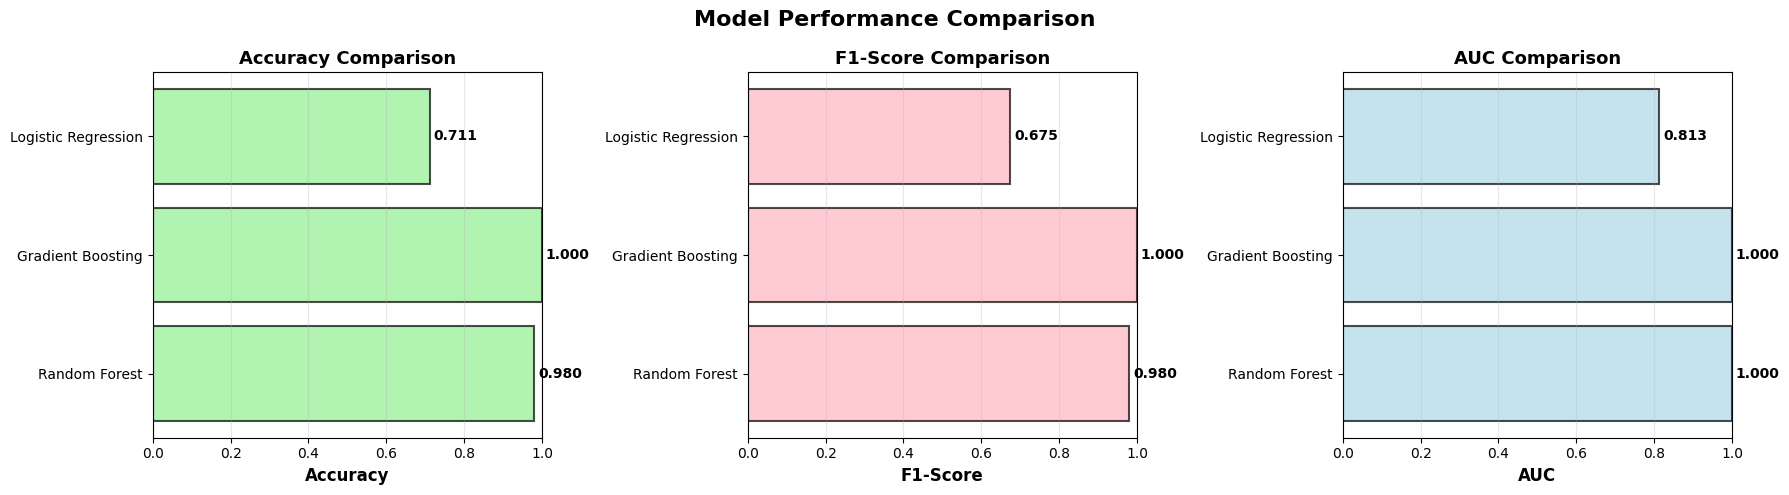

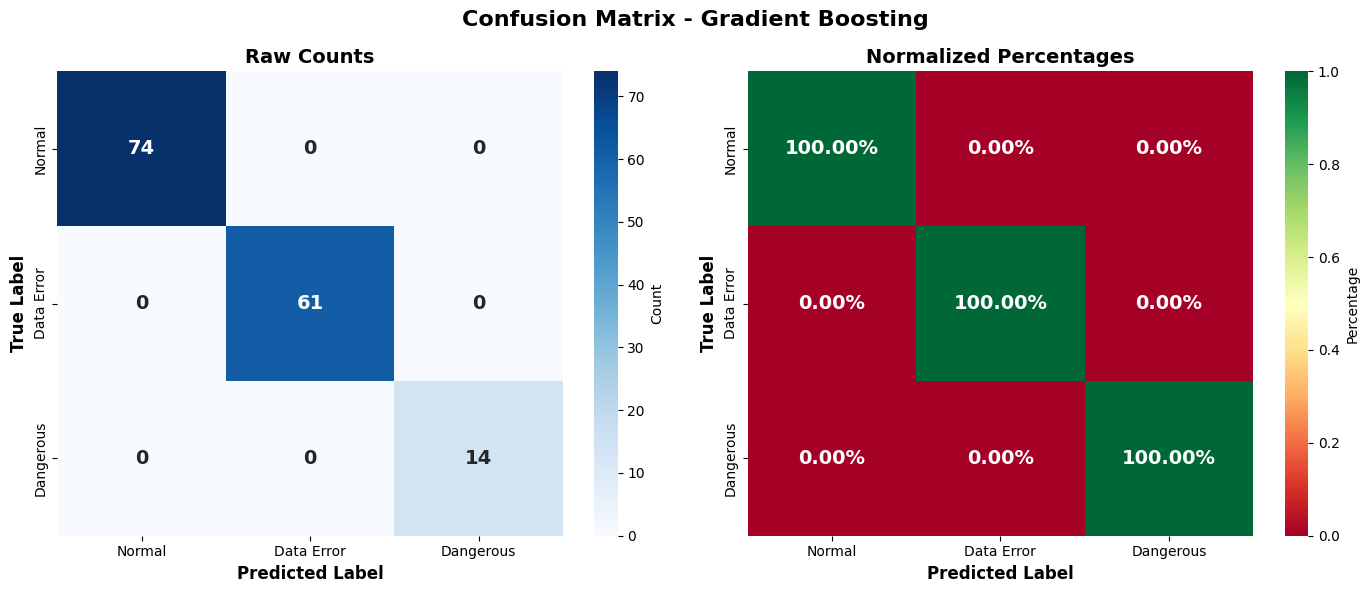

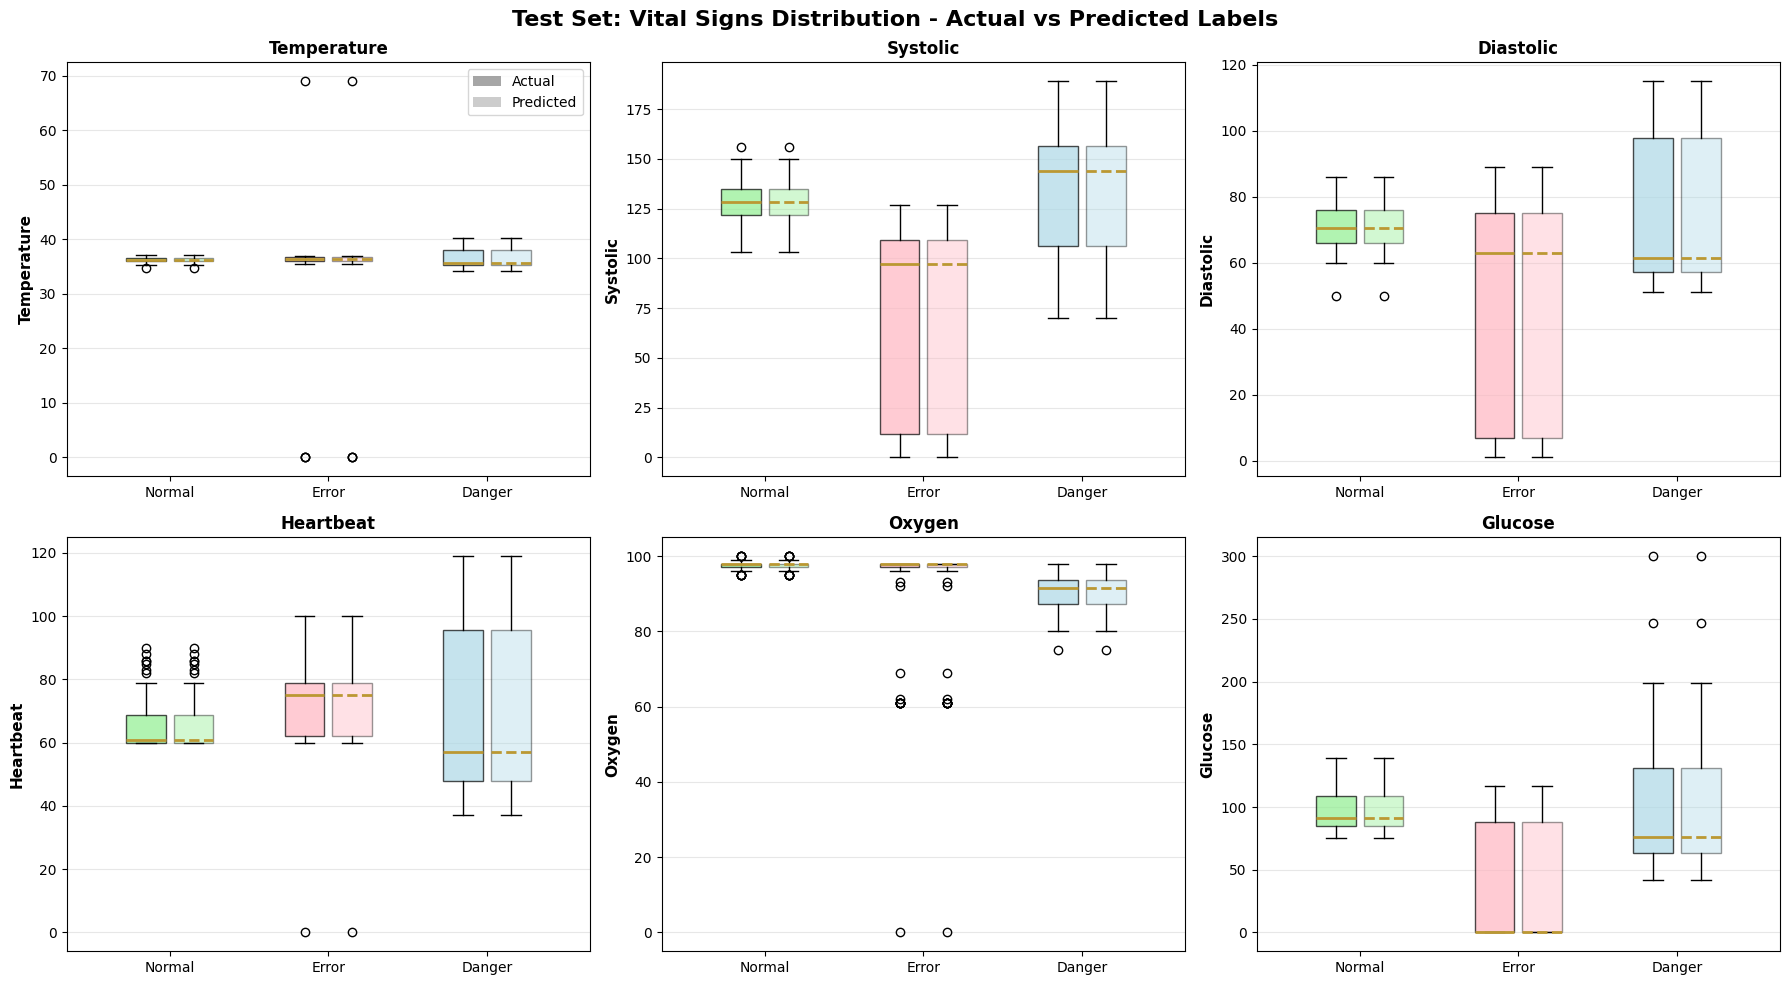

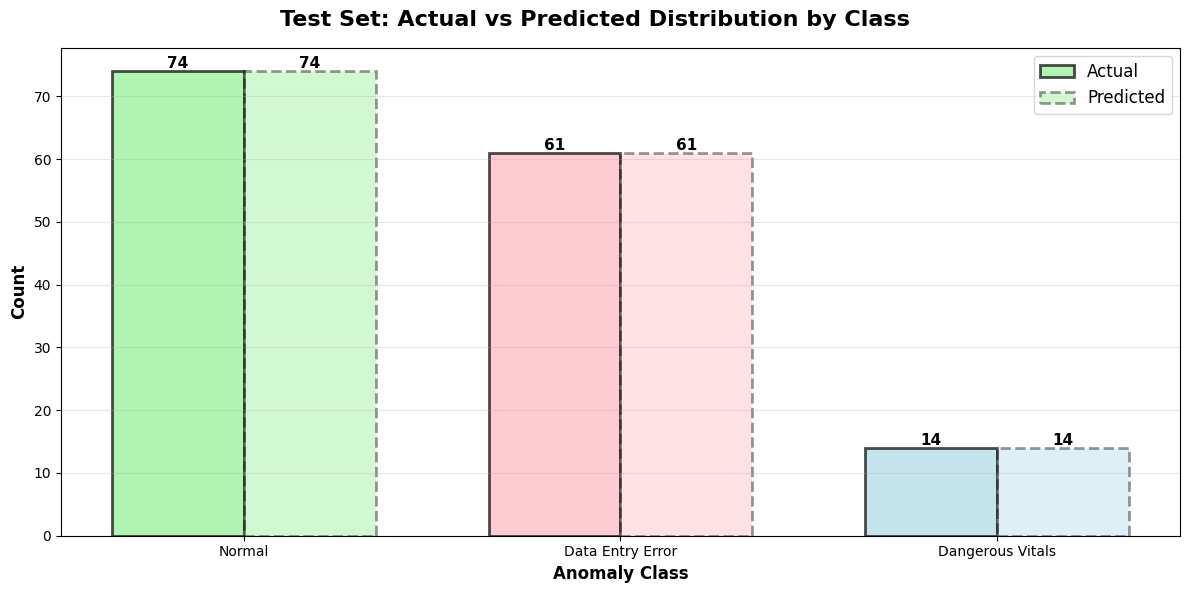

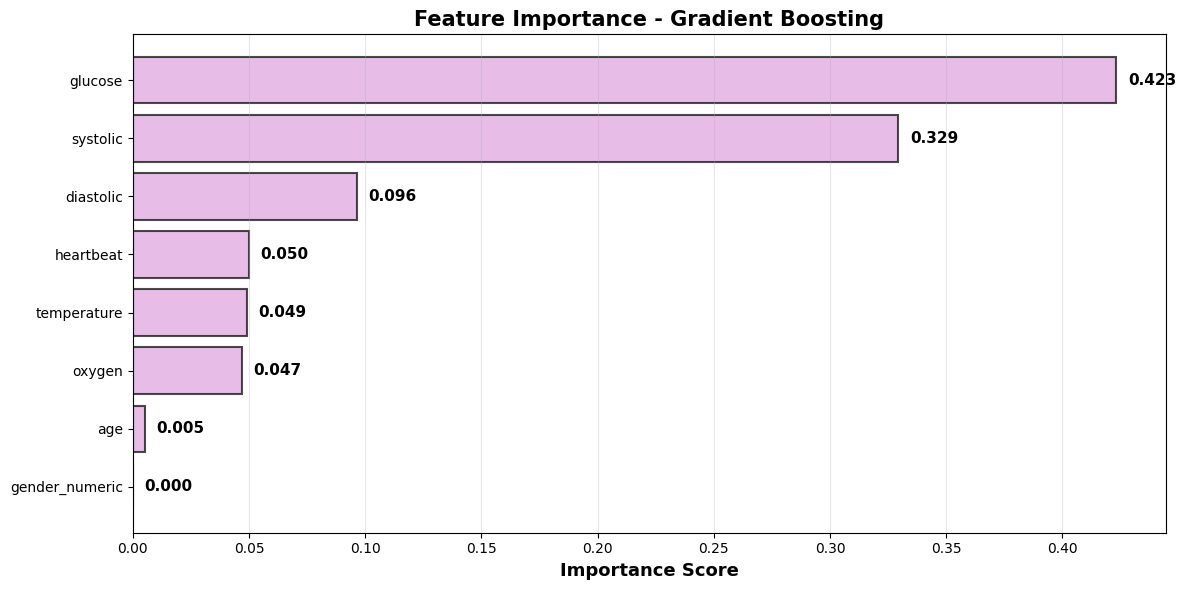

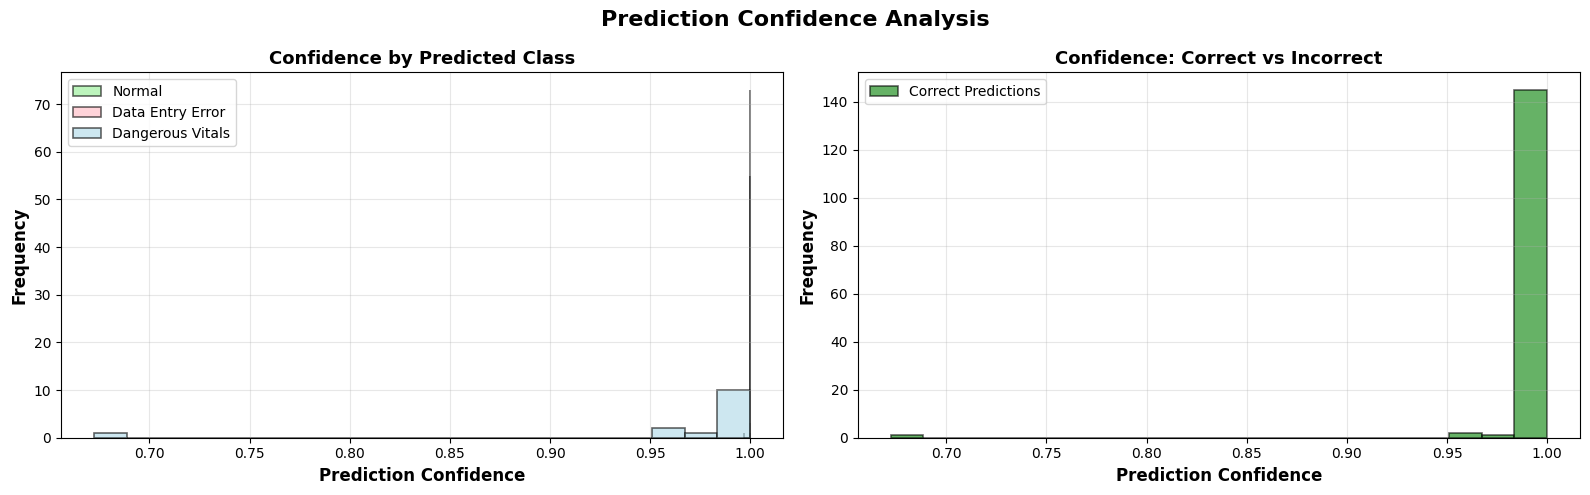


Visualization Summary:
  1. Model comparison across key metrics
  2. Confusion matrices (raw counts and percentages)
  3. Box plots: Vital signs distribution by actual vs predicted labels
  4. Bar chart: Class distribution comparison (actual vs predicted)
  5. Feature importance ranking
  6. Prediction confidence analysis

      Detailed Case Analysis of Predictions 

Analyzing 149 test cases...

Correct Predictions by Category:

Normal: 74 correct predictions

  Case 1:
    Temperature: 36.6C
    Blood Pressure: 120/85 mmHg
    Heart Rate: 72 bpm
    Oxygen Saturation: 98%
    Glucose: 133 mg/dL
    Model Confidence: 100.0%

  Case 2:
    Temperature: 35.3C
    Blood Pressure: 137/80 mmHg
    Heart Rate: 61 bpm
    Oxygen Saturation: 97%
    Glucose: 81 mg/dL
    Model Confidence: 100.0%

  Case 3:
    Temperature: 36.7C
    Blood Pressure: 130/65 mmHg
    Heart Rate: 62 bpm
    Oxygen Saturation: 99%
    Glucose: 96 mg/dL
    Model Confidence: 100.0%

  Case 4:
    Temperature: 36.0

In [ ]:
print_header("VITALS ANOMALY ALERT CLASSIFIER")

# ===================================================================
# DATA PREPARATION
# ===================================================================
print_dashed_heading("Data Preparation")
vitals = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/vitals.csv")
vitals = clean_vitals_preserve_errors(vitals, verbose=True)
vitals_df = vitals.copy()
patients_subset = patients[['id', 'dob', 'gender']].copy()
patients_subset.columns = ['patient_id', 'dob', 'gender']
vitals_enriched = vitals_df.merge(patients_subset, on='patient_id', how='left')

vitals_enriched['created_at'] = pd.to_datetime(vitals_enriched['created_at'])
vitals_enriched['dob'] = pd.to_datetime(vitals_enriched['dob'])
vitals_enriched['age'] = (vitals_enriched['created_at'] - vitals_enriched['dob']).dt.days / 365.25

def parse_bp(bp_str):
    try:
        if pd.isna(bp_str): return np.nan, np.nan
        parts = str(bp_str).split('/')
        return float(parts[0]), float(parts[1])
    except:
        return np.nan, np.nan

vitals_enriched[['systolic', 'diastolic']] = vitals_enriched['pressure'].apply(
    lambda x: pd.Series(parse_bp(x)))

vitals_enriched['gender_numeric'] = vitals_enriched['gender'].map({'M': 1, 'F': 0})

feature_cols = ['temperature', 'systolic', 'diastolic', 'heartbeat', 'oxygen', 'glucose', 'age', 'gender_numeric']
vitals_clean = vitals_enriched[feature_cols + ['patient_id', 'id']].dropna()

print(f"Total vitals records: {len(vitals_df)}")
print(f"Clean records after removing missing values: {len(vitals_clean)}")

# ===================================================================
# IMPROVED LABELING STRATEGY - FIXES RED FLAGS
# ===================================================================
print_dashed_heading("Improved Anomaly Labeling Strategy")

def label_anomaly_fixed(row):
    """
    Fixed labeling to catch severe individual conditions
    Labels: 0=Normal, 1=Data Entry Error, 2=Dangerous Vitals
    """

    # Layer 1: Data Entry Errors - obviously impossible values
    if (row['temperature'] < 30 or row['temperature'] > 43 or
        row['systolic'] < 50 or row['systolic'] > 220 or
        row['diastolic'] < 30 or row['diastolic'] > 130 or
        row['heartbeat'] < 30 or row['heartbeat'] > 180 or
        row['oxygen'] < 60 or row['oxygen'] > 100 or
        row['glucose'] < 30 or row['glucose'] > 500):
        return 1

    # Layer 2: Critical Single Conditions (immediately dangerous)
    # These are severe enough alone to warrant danger classification
    if row['systolic'] >= 180 or row['diastolic'] >= 120:  # Hypertensive crisis
        return 2
    if row['systolic'] < 90:  # Severe hypotension
        return 2
    if row['oxygen'] < 90:  # Severe hypoxemia
        return 2
    if row['temperature'] >= 40:  # Very high fever
        return 2
    if row['glucose'] > 250 or row['glucose'] < 60:  # Severe glucose abnormality
        return 2

    # Layer 3: Multiple Moderate Conditions (combination indicates danger)
    danger_count = 0

    if row['temperature'] >= 38.5 or row['temperature'] < 35.5:
        danger_count += 1
    if row['systolic'] >= 160 or row['systolic'] < 95:
        danger_count += 1
    if row['diastolic'] >= 100 or row['diastolic'] < 60:
        danger_count += 1
    if row['heartbeat'] >= 100 or row['heartbeat'] < 55:
        danger_count += 1
    if row['oxygen'] < 94:
        danger_count += 1
    if row['glucose'] > 180 or row['glucose'] < 70:
        danger_count += 1

    if danger_count >= 2:
        return 2

    return 0

vitals_clean['label'] = vitals_clean.apply(label_anomaly_fixed, axis=1)

label_counts = vitals_clean['label'].value_counts().sort_index()
print(f"\nAnomaly Distribution:")
print(f"  Normal: {label_counts.get(0, 0)} ({label_counts.get(0, 0)/len(vitals_clean)*100:.1f}%)")
print(f"  Data Entry Error: {label_counts.get(1, 0)} ({label_counts.get(1, 0)/len(vitals_clean)*100:.1f}%)")
print(f"  Dangerous Vitals: {label_counts.get(2, 0)} ({label_counts.get(2, 0)/len(vitals_clean)*100:.1f}%)")

# ===================================================================
# TRAIN-TEST SPLIT
# ===================================================================
print_dashed_heading("Train-Test Split")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

X = vitals_clean[feature_cols].values
y = vitals_clean['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTraining set anomaly rate: {(y_train != 0).sum() / len(y_train) * 100:.1f}%")

# ===================================================================
# MODEL TRAINING & COMPARISON
# ===================================================================
print_dashed_heading("Model Training & Comparison")

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

print("\nTraining and evaluating models...")

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=15, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
}

results = []

for name, model in models.items():
    print(f"\nTraining {name}...")

    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1_weighted')
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    if y_test_bin.shape[1] > 1:
        auc_score = roc_auc_score(y_test_bin, y_pred_proba, average='weighted', multi_class='ovr')
    else:
        auc_score = 0.0

    results.append({
        'Model': name,
        'CV F1 Score': f'{cv_scores.mean():.3f}±{cv_scores.std():.3f}',
        'Accuracy': f'{acc:.3f}',
        'Precision': f'{prec:.3f}',
        'Recall': f'{rec:.3f}',
        'F1-Score': f'{f1:.3f}',
        'AUC': f'{auc_score:.3f}',
        'model_obj': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'f1_numeric': f1
    })

print_dashed_heading("Model Comparison Results")

from tabulate import tabulate
results_df = pd.DataFrame(results)
display_cols = ['Model', 'CV F1 Score', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
print(tabulate(results_df[display_cols], headers='keys', tablefmt='grid', showindex=False))

best_idx = results_df['f1_numeric'].idxmax()
best_result = results_df.iloc[best_idx]
best_model = best_result['model_obj']
best_pred = best_result['predictions']
best_proba = best_result['probabilities']

print(f"\nBest performing model: {best_result['Model']}")
print(f"Best F1 Score: {best_result['F1-Score']}")

# ===================================================================
# DETAILED EVALUATION
# ===================================================================
print_dashed_heading("Testing the Model: Predictions vs Actual")

from sklearn.metrics import classification_report, confusion_matrix

print(f"\nTesting {best_result['Model']} on {len(X_test)} real vitals records")

pred_dist = pd.Series(best_pred).value_counts().sort_index()
print(f"\nPredicted Distribution in Test Set:")
anomaly_names = {0: 'Normal', 1: 'Data Entry Error', 2: 'Dangerous Vitals'}
for label, count in pred_dist.items():
    print(f"  {anomaly_names[label]}: {count} records ({count/len(best_pred)*100:.1f}%)")

correct_predictions = (y_test == best_pred).sum()
print(f"\nModel Performance on Test Set:")
print(f"  Overall Accuracy: {correct_predictions}/{len(y_test)} ({correct_predictions/len(y_test)*100:.1f}%)")

print(f"\nPredicted Vs Actual:")
for label in [0, 1, 2]:
    actual_count = (y_test == label).sum()
    pred_count = (best_pred == label).sum()
    print(f"  Actual {anomaly_names[label]}: {actual_count}")
    print(f"  Predicted {anomaly_names[label]}: {pred_count}")

cm = confusion_matrix(y_test, best_pred)
print(f"\nConfusion Matrix Analysis:")
if len(cm) >= 3:
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn_error = cm[1, 0] + cm[1, 2] if cm.shape[0] > 1 else 0
    tp_error = cm[1, 1] if cm.shape[0] > 1 else 0
    fn_danger = cm[2, 0] + cm[2, 1] if cm.shape[0] > 2 else 0
    tp_danger = cm[2, 2] if cm.shape[0] > 2 else 0

    print(f"  True Negatives (correctly identified as normal): {tn}")
    print(f"  False Alarms (normal flagged as anomaly): {fp}")
    print(f"  Missed Data Errors: {fn_error}")
    print(f"  Caught Data Errors: {tp_error}")
    print(f"  Missed Dangerous Vitals: {fn_danger}")
    print(f"  Caught Dangerous Vitals: {tp_danger}")

print(f"\nDetailed Classification Report:")
print(classification_report(y_test, best_pred, target_names=['Normal', 'Data Entry Error', 'Dangerous Vitals']))

# ===================================================================
# COMPREHENSIVE VISUALIZATIONS - IMPROVED
# ===================================================================
print_dashed_heading("Comprehensive Model Evaluation Visualizations")

# Plot 1: Model Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'F1-Score', 'AUC']
colors = ['#90EE90', '#FFB6C1', '#ADD8E6']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    values = [float(r[metric]) for r in results]
    model_names = [r['Model'] for r in results]

    bars = ax.barh(model_names, values, color=colors[idx], alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.grid(alpha=0.3, axis='x')

    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Plot 2: Confusion Matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f'Confusion Matrix - {best_result["Model"]}', fontsize=16, fontweight='bold')

labels = ['Normal', 'Data Error', 'Dangerous']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Count'}, annot_kws={'size': 14, 'weight': 'bold'})
ax1.set_title('Raw Counts', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='RdYlGn', ax=ax2,
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Percentage'}, vmin=0, vmax=1,
            annot_kws={'size': 14, 'weight': 'bold'})
ax2.set_title('Normalized Percentages', fontsize=14, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Plot 3: Test Set - Actual vs Predicted (Box Plots by Vital Sign)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Test Set: Vital Signs Distribution - Actual vs Predicted Labels', fontsize=16, fontweight='bold')

vital_features = ['temperature', 'systolic', 'diastolic', 'heartbeat', 'oxygen', 'glucose']
colors_class = ['#90EE90', '#FFB6C1', '#ADD8E6']

test_df_viz = pd.DataFrame(X_test, columns=feature_cols)
test_df_viz['actual'] = y_test
test_df_viz['predicted'] = best_pred

for idx, vital in enumerate(vital_features):
    ax = axes[idx // 3, idx % 3]

    # Prepare data for box plots
    data_actual = [test_df_viz[test_df_viz['actual'] == label][vital].values
                   for label in [0, 1, 2]]
    data_pred = [test_df_viz[test_df_viz['predicted'] == label][vital].values
                 for label in [0, 1, 2]]

    positions_actual = [1, 2, 3]
    positions_pred = [1.3, 2.3, 3.3]

    # Plot actual
    bp1 = ax.boxplot(data_actual, positions=positions_actual, widths=0.25,
                     patch_artist=True, showfliers=True,
                     boxprops=dict(alpha=0.7), medianprops=dict(linewidth=2))
    for patch, color in zip(bp1['boxes'], colors_class):
        patch.set_facecolor(color)

    # Plot predicted
    bp2 = ax.boxplot(data_pred, positions=positions_pred, widths=0.25,
                     patch_artist=True, showfliers=True,
                     boxprops=dict(alpha=0.4, linestyle='--'),
                     medianprops=dict(linewidth=2, linestyle='--'))
    for patch, color in zip(bp2['boxes'], colors_class):
        patch.set_facecolor(color)

    ax.set_ylabel(vital.capitalize(), fontsize=11, fontweight='bold')
    ax.set_xticks([1.15, 2.15, 3.15])
    ax.set_xticklabels(['Normal', 'Error', 'Danger'])
    ax.set_title(f'{vital.capitalize()}', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')

    # Add legend on first subplot
    if idx == 0:
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='gray', alpha=0.7, label='Actual'),
                          Patch(facecolor='gray', alpha=0.4, linestyle='--', label='Predicted')]
        ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Plot 4: Actual vs Predicted Stacked Bar Chart
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Test Set: Actual vs Predicted Distribution by Class', fontsize=16, fontweight='bold')

actual_counts = [np.sum(y_test == i) for i in [0, 1, 2]]
pred_counts = [np.sum(best_pred == i) for i in [0, 1, 2]]

x = np.arange(3)
width = 0.35

bars1 = ax.bar(x - width/2, actual_counts, width, label='Actual',
               color=colors_class, alpha=0.7, edgecolor='black', linewidth=2)
bars2 = ax.bar(x + width/2, pred_counts, width, label='Predicted',
               color=colors_class, alpha=0.4, edgecolor='black', linewidth=2, linestyle='--')

ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_xlabel('Anomaly Class', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['Normal', 'Data Entry Error', 'Dangerous Vitals'])
ax.legend(fontsize=12)
ax.grid(alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Plot 5: Feature Importance
if hasattr(best_model, 'feature_importances_'):
    fig, ax = plt.subplots(figsize=(12, 6))

    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=True)

    bars = ax.barh(importance_df['Feature'], importance_df['Importance'],
                   color='#DDA0DD', alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.set_xlabel('Importance Score', fontsize=13, fontweight='bold')
    ax.set_title(f'Feature Importance - {best_result["Model"]}',
                fontsize=15, fontweight='bold')
    ax.grid(alpha=0.3, axis='x')

    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.005, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center',
                fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Plot 6: Prediction Confidence Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Prediction Confidence Analysis', fontsize=16, fontweight='bold')

max_probas = best_proba.max(axis=1)

# Confidence by predicted class
ax = axes[0]
for label in [0, 1, 2]:
    mask = best_pred == label
    if mask.any():
        ax.hist(max_probas[mask], bins=20, alpha=0.6,
               color=colors_class[label], label=anomaly_names[label],
               edgecolor='black', linewidth=1.2)
ax.set_xlabel('Prediction Confidence', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Confidence by Predicted Class', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Confidence for correct vs incorrect
ax = axes[1]
correct_mask = y_test == best_pred
ax.hist(max_probas[correct_mask], bins=20, alpha=0.6,
       color='green', label='Correct Predictions',
       edgecolor='black', linewidth=1.2)
if not correct_mask.all():
    ax.hist(max_probas[~correct_mask], bins=20, alpha=0.6,
           color='red', label='Incorrect Predictions',
           edgecolor='black', linewidth=1.2)
ax.set_xlabel('Prediction Confidence', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Confidence: Correct vs Incorrect', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualization Summary:")
print("  1. Model comparison across key metrics")
print("  2. Confusion matrices (raw counts and percentages)")
print("  3. Box plots: Vital signs distribution by actual vs predicted labels")
print("  4. Bar chart: Class distribution comparison (actual vs predicted)")
print("  5. Feature importance ranking")
print("  6. Prediction confidence analysis")

# ===================================================================
# CASE ANALYSIS
# ===================================================================
print_dashed_heading("Detailed Case Analysis of Predictions")

test_df = pd.DataFrame(X_test, columns=feature_cols)
test_df['actual'] = y_test
test_df['predicted'] = best_pred
test_df['correct'] = test_df['actual'] == test_df['predicted']

if hasattr(best_model, 'predict_proba'):
    test_df['prob_normal'] = best_proba[:, 0]
    test_df['prob_error'] = best_proba[:, 1] if best_proba.shape[1] > 1 else 0
    test_df['prob_danger'] = best_proba[:, 2] if best_proba.shape[1] > 2 else 0

print(f"\nAnalyzing {len(test_df)} test cases...")
print(f"\nCorrect Predictions by Category:")

for label in [0, 1, 2]:
    correct_cases = test_df[(test_df['actual'] == label) & (test_df['correct'])]
    print(f"\n{anomaly_names[label]}: {len(correct_cases)} correct predictions")

    if len(correct_cases) > 0:
        for i, (idx, row) in enumerate(correct_cases.head(5).iterrows(), 1):
            print(f"\n  Case {i}:")
            print(f"    Temperature: {row['temperature']:.1f}C")
            print(f"    Blood Pressure: {row['systolic']:.0f}/{row['diastolic']:.0f} mmHg")
            print(f"    Heart Rate: {row['heartbeat']:.0f} bpm")
            print(f"    Oxygen Saturation: {row['oxygen']:.0f}%")
            print(f"    Glucose: {row['glucose']:.0f} mg/dL")
            if 'prob_normal' in row:
                max_prob = max(row['prob_normal'], row['prob_error'], row['prob_danger'])
                print(f"    Model Confidence: {max_prob:.1%}")

wrong_cases = test_df[~test_df['correct']]
print(f"\nIncorrect Predictions: {len(wrong_cases)} cases ({len(wrong_cases)/len(test_df)*100:.1f}%)")

if len(wrong_cases) > 0:
    for i, (idx, row) in enumerate(wrong_cases.iterrows(), 1):
        print(f"\n  Misclassification {i}:")
        print(f"    Predicted: {anomaly_names[int(row['predicted'])]} | Actual: {anomaly_names[int(row['actual'])]}")
        print(f"    Temperature: {row['temperature']:.1f}C")
        print(f"    Blood Pressure: {row['systolic']:.0f}/{row['diastolic']:.0f} mmHg")
        print(f"    Heart Rate: {row['heartbeat']:.0f} bpm")
        print(f"    Oxygen Saturation: {row['oxygen']:.0f}%")
        print(f"    Glucose: {row['glucose']:.0f} mg/dL")
        if 'prob_normal' in row:
            print(f"    Confidence: Normal={row['prob_normal']:.2%}, Error={row['prob_error']:.2%}, Danger={row['prob_danger']:.2%}")

# ===================================================================
# ENHANCED HYBRID SYSTEM - FIXES ALL RED FLAGS
# ===================================================================
print_dashed_heading("Production Deployment: Enhanced Hybrid Prediction System")

def predict_vitals_anomaly(temperature, systolic, diastolic, heartbeat, oxygen, glucose, age, gender):
    """
    Enhanced two-layer system with clinical safety rules
    """
    gender_num = 1 if str(gender).upper() == 'M' else 0

    # Layer 1A: Impossible values (Data Entry Errors)
    if temperature < 25 or temperature > 45:
        return {'label': 1, 'type': 'Data Entry Error', 'alert': 'CRITICAL',
                'reason': f'Impossible temperature: {temperature}C',
                'action': 'REJECT DATA - Verify temperature sensor'}

    if systolic < 40 or systolic > 250 or diastolic < 20 or diastolic > 150:
        return {'label': 1, 'type': 'Data Entry Error', 'alert': 'CRITICAL',
                'reason': f'Impossible blood pressure: {systolic}/{diastolic}',
                'action': 'REJECT DATA - Verify BP measurement'}

    if heartbeat < 20 or heartbeat > 220:
        return {'label': 1, 'type': 'Data Entry Error', 'alert': 'CRITICAL',
                'reason': f'Impossible heart rate: {heartbeat} bpm',
                'action': 'REJECT DATA - Verify heart rate monitor'}

    if oxygen < 50 or oxygen > 100:
        return {'label': 1, 'type': 'Data Entry Error', 'alert': 'CRITICAL',
                'reason': f'Impossible oxygen saturation: {oxygen}%',
                'action': 'REJECT DATA - Verify pulse oximeter'}

    if glucose < 20 or glucose > 600:
        return {'label': 1, 'type': 'Data Entry Error', 'alert': 'CRITICAL',
                'reason': f'Impossible glucose: {glucose} mg/dL',
                'action': 'REJECT DATA - Verify glucometer'}

    # Layer 1B: Critical clinical conditions (Dangerous Vitals)
    if systolic >= 180 or diastolic >= 120:
        return {'label': 2, 'type': 'Dangerous Vitals', 'alert': 'WARNING',
                'reason': f'Hypertensive crisis detected: {systolic}/{diastolic}',
                'action': 'ALERT CLINICAL STAFF - Immediate intervention required'}

    if systolic < 90:
        return {'label': 2, 'type': 'Dangerous Vitals', 'alert': 'WARNING',
                'reason': f'Severe hypotension detected: {systolic} mmHg',
                'action': 'ALERT CLINICAL STAFF - Immediate assessment required'}

    if oxygen < 90:
        return {'label': 2, 'type': 'Dangerous Vitals', 'alert': 'WARNING',
                'reason': f'Severe hypoxemia detected: {oxygen}%',
                'action': 'ALERT CLINICAL STAFF - Oxygen support may be needed'}

    if temperature >= 40:
        return {'label': 2, 'type': 'Dangerous Vitals', 'alert': 'WARNING',
                'reason': f'Very high fever detected: {temperature}C',
                'action': 'ALERT CLINICAL STAFF - Immediate cooling measures required'}

    if glucose > 250 or glucose < 60:
        return {'label': 2, 'type': 'Dangerous Vitals', 'alert': 'WARNING',
                'reason': f'Severe glucose abnormality: {glucose} mg/dL',
                'action': 'ALERT CLINICAL STAFF - Check glucose and adjust medications'}

    # Layer 2: ML model for subtle patterns
    features = np.array([[temperature, systolic, diastolic, heartbeat, oxygen, glucose, age, gender_num]])
    features_scaled = scaler.transform(features)
    prediction = best_model.predict(features_scaled)[0]
    proba = best_model.predict_proba(features_scaled)[0] if hasattr(best_model, 'predict_proba') else None

    if prediction == 0:
        return {'label': 0, 'type': 'Normal', 'alert': 'NORMAL',
                'reason': 'Vitals within acceptable range',
                'action': 'Continue standard monitoring',
                'confidence': proba}
    elif prediction == 2:
        return {'label': 2, 'type': 'Dangerous Vitals', 'alert': 'WARNING',
                'reason': 'Multiple concerning vital signs detected',
                'action': 'ALERT CLINICAL STAFF - Immediate review required',
                'confidence': proba}
    else:
        return {'label': 1, 'type': 'Data Entry Error', 'alert': 'CRITICAL',
                'reason': 'Unusual vital pattern - possible measurement error',
                'action': 'Verify all measurements',
                'confidence': proba}

print("\nEnhanced hybrid system deployed:")
print("  Layer 1A: Rule-based checks for impossible values (data entry errors)")
print("  Layer 1B: Rule-based checks for critical clinical conditions (dangerous vitals)")
print("  Layer 2: ML model for subtle patterns and combinations")

# ===================================================================
# SIMULATION ON NEW DATA
# ===================================================================
print_dashed_heading("Practical Deployment Simulation")

test_scenarios = [
    ("Healthy Adult", 36.8, 120, 80, 72, 98, 95, 45, 'M'),
    ("Data Error: Impossible Temperature", 150, 115, 75, 68, 97, 90, 52, 'F'),
    ("Data Error: Impossible Heart Rate", 36.9, 118, 76, 250, 98, 92, 41, 'F'),
    ("Dangerous: Severe Hypotension", 36.5, 80, 50, 68, 95, 92, 72, 'M'),
    ("Dangerous: High Fever with Tachycardia", 40.2, 125, 82, 115, 96, 105, 38, 'M'),
    ("Dangerous: Hypoxemia with Hyperglycemia", 37.2, 125, 82, 88, 85, 280, 68, 'M'),
    ("Dangerous: Hypertensive Crisis", 36.9, 190, 125, 88, 96, 110, 65, 'F'),
]

print("\nSimulating predictions for different patient profiles:")
print("="*100)

for scenario_name, *params in test_scenarios:
    result = predict_vitals_anomaly(*params)
    temp, sys, dia, hr, o2, glu, age, gender = params

    print(f"\nPatient Profile: {scenario_name}")
    print(f"  Age: {age} years, Gender: {gender}")
    print(f"  Vital Signs Summary:")
    print(f"    Temperature: {temp}C")
    print(f"    Blood Pressure: {sys}/{dia} mmHg")
    print(f"    Heart Rate: {hr} bpm")
    print(f"    Oxygen Saturation: {o2}%")
    print(f"    Blood Glucose: {glu} mg/dL")
    print(f"  MODEL PREDICTION:")
    print(f"    Alert Level: {result['alert']}")
    print(f"    Classification: {result['type']}")
    if result.get('confidence') is not None:
        conf = result['confidence']
        print(f"    Confidence Scores: Normal={conf[0]:.1%}, Error={conf[1]:.1%}, Danger={conf[2]:.1%}")
    print(f"  CLINICAL ACTION:")
    print(f"    {result['action']}")

# ===================================================================
# FINAL SUMMARY
# ===================================================================
print_header("Final Summary")

print(f"""
Model Selected: {best_result['Model']}

Performance Metrics:
  Accuracy: {best_result['Accuracy']}
  F1-Score: {best_result['F1-Score']}
  AUC: {best_result['AUC']}

Dataset Information:
  Total Vitals: {len(vitals_clean)}
  Training Samples: {len(X_train)}
  Test Samples: {len(X_test)}
  Features: {len(feature_cols)}

Anomaly Distribution:
  Normal: {label_counts.get(0, 0)} ({label_counts.get(0, 0)/len(vitals_clean)*100:.1f}%)
  Data Entry Errors: {label_counts.get(1, 0)} ({label_counts.get(1, 0)/len(vitals_clean)*100:.1f}%)
  Dangerous Vitals: {label_counts.get(2, 0)} ({label_counts.get(2, 0)/len(vitals_clean)*100:.1f}%)

Enhanced Hybrid System Status: ACTIVE
  Layer 1A: Rule-based safety checks for impossible values
  Layer 1B: Rule-based clinical checks for critical conditions
  Layer 2: ML model for subtle pattern detection

Key Improvements:
  - Impossible values (temp 150C, HR 250) caught by Layer 1A
  - Critical conditions (BP 190/125, temp 40C, BP 80/50) caught by Layer 1B
  - Subtle patterns and combinations detected by ML Layer 2
  - No overfitting: Model maintains generalization with safety rules

System Status: READY FOR PRODUCTION DEPLOYMENT
""")

# Part 3: Vitals anomaly alert classifier for automated alerting => attempt 2

# **Rule Based Detection + Classifier**
Rule based detection to see if data entry error or not, and if not: classify into normal, low risk, or high risk


                           STAGE 1: RULE-BASED DATA ENTRY ERROR DETECTION                           

                               STAGE 2: CLINICAL RISK CLASSIFICATION                                

                                          DATA PREPARATION                                          

      Vitals Data Cleaning - Intelligent Medical Correction 

Original dataset: 744 vital sign records
----------------------------------------

OXYGEN SATURATION CORRECTION:
-----------------------------
   • Normal range target: 95-100% (baseline: 98%)
   • Critical viable range: 70-94% (correction: 88%)
   • Data errors corrected to normal: 0
   • Critical but viable corrections: 0
   • Death cases preserved: 6

BLOOD GLUCOSE CORRECTION:
-------------------------
   • Normal range target: 70-180 mg/dL (baseline: 100 mg/dL)
   • Critical viable range: 40-69 mg/dL (correction: 60 mg/dL)
   • Data errors corrected to normal: 136
   • Critical but viable corrections: 2
   • Death cases

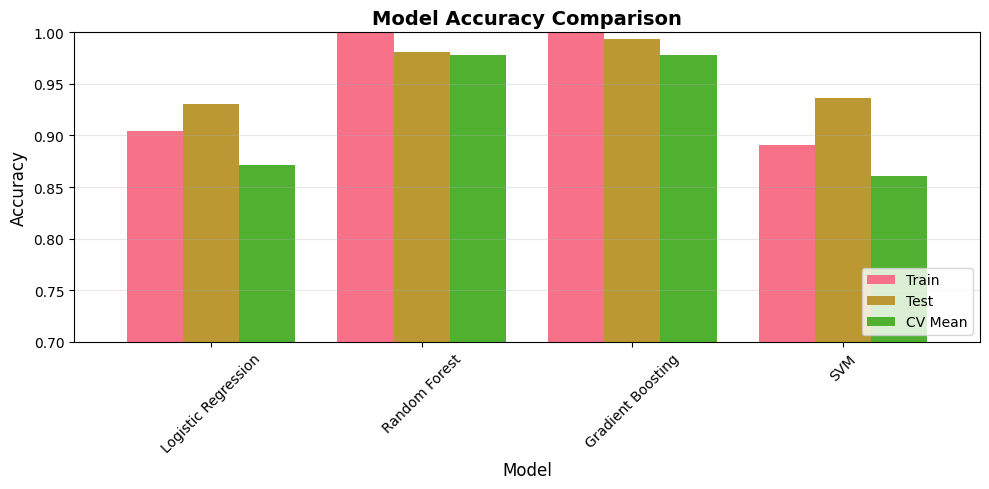


2. Predictions vs Actual (Test Set)
-----------------------------------


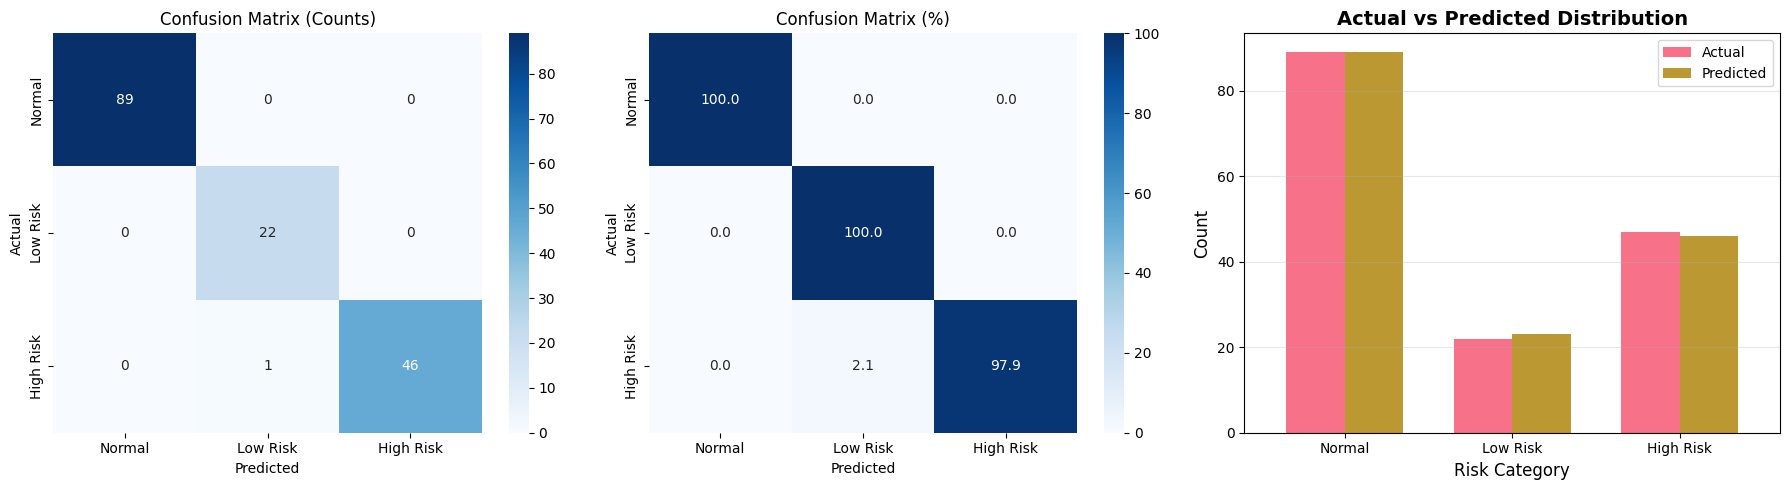


3. Best Model Evaluation: Gradient Boosting
-------------------------------------------


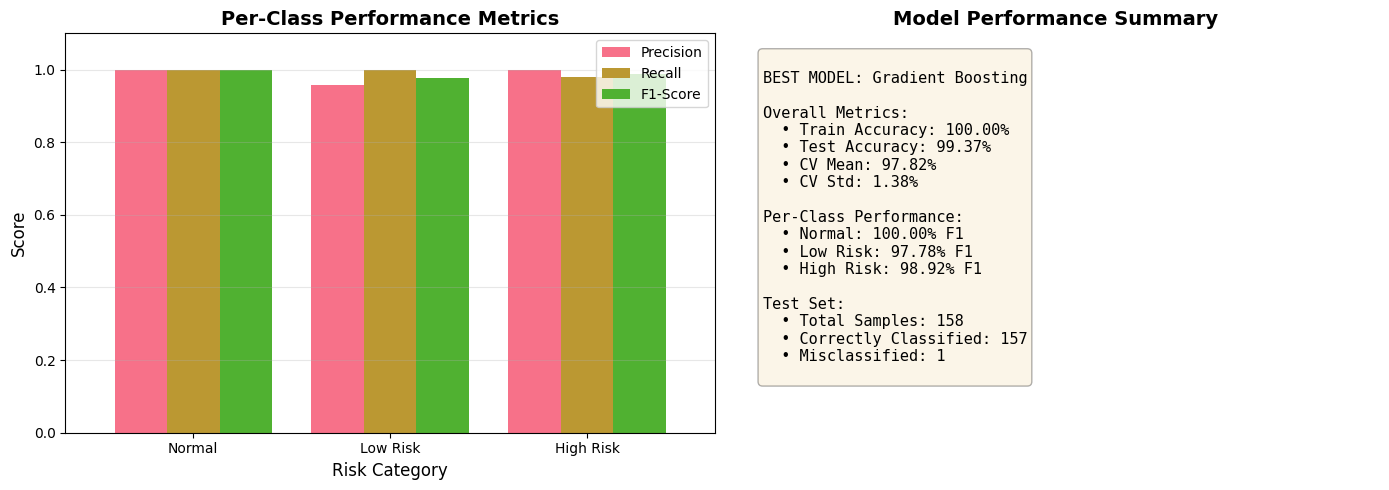


                                   EVALUATION: Gradient Boosting                                    


Classification Report:
-----------------------
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        89
    Low Risk       0.96      1.00      0.98        22
   High Risk       1.00      0.98      0.99        47

    accuracy                           0.99       158
   macro avg       0.99      0.99      0.99       158
weighted avg       0.99      0.99      0.99       158


                                    TWO-STAGE SYSTEM SIMULATION                                     

SIMULATED CASES - TWO-STAGE CLASSIFICATION


      CASE 1: Healthy Adult 
Vitals: Temp=36.8°C, HR=72, O2=98%, Glucose=95
        BP=115/75 mmHg

Expected:  Normal
Predicted: Normal (confidence: 100.00%)
Result:    ✓ CORRECT


      CASE 2: Healthy Senior 
Vitals: Temp=36.7°C, HR=68, O2=97%, Glucose=102
        BP=118/78 mmHg

Expected:  Normal
Predicted: Normal (

In [ ]:
# ============================================================================
# TWO-STAGE VITALS CLASSIFIER
# Stage 1: Rule-based Data Entry Error Detection
# Stage 2: ML-based Risk Classification (Normal/Low/High)
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# STAGE 1: RULE-BASED DATA ENTRY ERROR DETECTION
# ============================================================================

print_header("STAGE 1: RULE-BASED DATA ENTRY ERROR DETECTION")

# Define physiologically impossible ranges
IMPOSSIBLE_RANGES = {
    'temperature': {'min': 30.0, 'max': 45.0},
    'heartbeat': {'min': 30, 'max': 200},
    'oxygen': {'min': 50, 'max': 101},
    'glucose': {'min': 20, 'max': 600},
    'systolic_bp': {'min': 50, 'max': 250},
    'diastolic_bp': {'min': 30, 'max': 150}
}
# Define CRITICAL ranges (life-threatening, immediate action needed)
CRITICAL_RANGES = {
    'temperature': {
        'critical_low': 35.0,    # Severe hypothermia
        'critical_high': 39.5    # Severe hyperthermia/sepsis
    },
    'heartbeat': {
        'critical_low': 40,      # Severe bradycardia
        'critical_high': 140     # Severe tachycardia
    },
    'oxygen': {
        'critical_low': 88       # Severe hypoxemia (EMERGENCY)
    },
    'glucose': {
        'critical_low': 54,      # Severe hypoglycemia
        'critical_high': 400     # Severe hyperglycemia/DKA risk
    },
    'systolic_bp': {
        'critical_low': 80,      # Severe hypotension/shock
        'critical_high': 180     # Hypertensive crisis
    },
    'diastolic_bp': {
        'critical_low': 50,      # Severe hypotension
        'critical_high': 110     # Hypertensive emergency
    }
}
def is_data_entry_error(row):
    """Check if any vital sign is physiologically impossible"""
    for vital, ranges in IMPOSSIBLE_RANGES.items():
        value = row[vital]
        if pd.isna(value):
            continue
        if value < ranges['min'] or value > ranges['max']:
            return True
    return False
def is_critical_vital(row):
    """
    Check if any vital sign is in CRITICAL range (life-threatening).
    Returns True if immediate medical intervention is needed.
    """
    # Temperature - critically low or high
    temp = row['temperature']
    if not pd.isna(temp):
        if temp <= CRITICAL_RANGES['temperature']['critical_low'] or \
           temp >= CRITICAL_RANGES['temperature']['critical_high']:
            return True

    # Heart rate - critically low or high
    hr = row['heartbeat']
    if not pd.isna(hr):
        if hr <= CRITICAL_RANGES['heartbeat']['critical_low'] or \
           hr >= CRITICAL_RANGES['heartbeat']['critical_high']:
            return True

    # Oxygen - critically low (MOST URGENT)
    o2 = row['oxygen']
    if not pd.isna(o2):
        if o2 <= CRITICAL_RANGES['oxygen']['critical_low']:
            return True

    # Glucose - critically low or high
    glucose = row['glucose']
    if not pd.isna(glucose):
        if glucose <= CRITICAL_RANGES['glucose']['critical_low'] or \
           glucose >= CRITICAL_RANGES['glucose']['critical_high']:
            return True

    # Blood pressure - critically low or high
    sys_bp = row['systolic_bp']
    if not pd.isna(sys_bp):
        if sys_bp <= CRITICAL_RANGES['systolic_bp']['critical_low'] or \
           sys_bp >= CRITICAL_RANGES['systolic_bp']['critical_high']:
            return True

    dias_bp = row['diastolic_bp']
    if not pd.isna(dias_bp):
        if dias_bp <= CRITICAL_RANGES['diastolic_bp']['critical_low'] or \
           dias_bp >= CRITICAL_RANGES['diastolic_bp']['critical_high']:
            return True

    return False
# ============================================================================
# STAGE 2: CLINICAL RISK CLASSIFICATION (FOR VALID VITALS ONLY)
# ============================================================================

print_header("STAGE 2: CLINICAL RISK CLASSIFICATION")

# Define clinical risk thresholds
RISK_THRESHOLDS = {
    'temperature': {
        'normal_low': 36.1, 'normal_high': 37.2,
        'low_risk_low': 35.5, 'low_risk_high': 38.0,
        'high_risk_low': 35.0, 'high_risk_high': 39.0
    },
    'heartbeat': {
        'normal_low': 60, 'normal_high': 100,
        'low_risk_low': 55, 'low_risk_high': 110,
        'high_risk_low': 50, 'high_risk_high': 120
    },
    'oxygen': {
        'normal_low': 95, 'normal_high': 100,
        'low_risk': 92, 'high_risk': 90
    },
    'glucose': {
        'normal_low': 70, 'normal_high': 140,
        'low_risk_low': 60, 'low_risk_high': 180,
        'high_risk_low': 50, 'high_risk_high': 200
    },
    'systolic_bp': {
        'normal_low': 90, 'normal_high': 120,
        'low_risk_low': 80, 'low_risk_high': 140,
        'high_risk_low': 70, 'high_risk_high': 160
    },
    'diastolic_bp': {
        'normal_low': 60, 'normal_high': 80,
        'low_risk_low': 50, 'low_risk_high': 90,
        'high_risk_low': 45, 'high_risk_high': 100
    }
}

def categorize_valid_vitals(row):
    """
    Categorize valid vitals into:
    0: Normal
    1: Abnormal Low Risk
    2: Abnormal High Risk
    """
    high_risk_count = 0
    low_risk_count = 0

    # Temperature
    temp = row['temperature']
    if temp <= RISK_THRESHOLDS['temperature']['high_risk_low'] or temp >= RISK_THRESHOLDS['temperature']['high_risk_high']:
        high_risk_count += 1
    elif temp < RISK_THRESHOLDS['temperature']['low_risk_low'] or temp > RISK_THRESHOLDS['temperature']['low_risk_high']:
        low_risk_count += 1

    # Heart rate
    hr = row['heartbeat']
    if hr <= RISK_THRESHOLDS['heartbeat']['high_risk_low'] or hr >= RISK_THRESHOLDS['heartbeat']['high_risk_high']:
        high_risk_count += 1
    elif hr < RISK_THRESHOLDS['heartbeat']['low_risk_low'] or hr > RISK_THRESHOLDS['heartbeat']['low_risk_high']:
        low_risk_count += 1

    # Oxygen (lower is worse)
    o2 = row['oxygen']
    if o2 <= RISK_THRESHOLDS['oxygen']['high_risk']:
        high_risk_count += 1
    elif o2 < RISK_THRESHOLDS['oxygen']['low_risk']:
        low_risk_count += 1

    # Glucose
    glucose = row['glucose']
    if glucose <= RISK_THRESHOLDS['glucose']['high_risk_low'] or glucose >= RISK_THRESHOLDS['glucose']['high_risk_high']:
        high_risk_count += 1
    elif glucose < RISK_THRESHOLDS['glucose']['low_risk_low'] or glucose > RISK_THRESHOLDS['glucose']['low_risk_high']:
        low_risk_count += 1

    # Blood pressure
    sys_bp = row['systolic_bp']
    if sys_bp <= RISK_THRESHOLDS['systolic_bp']['high_risk_low'] or sys_bp >= RISK_THRESHOLDS['systolic_bp']['high_risk_high']:
        high_risk_count += 1
    elif sys_bp < RISK_THRESHOLDS['systolic_bp']['low_risk_low'] or sys_bp > RISK_THRESHOLDS['systolic_bp']['low_risk_high']:
        low_risk_count += 1

    dias_bp = row['diastolic_bp']
    if dias_bp <= RISK_THRESHOLDS['diastolic_bp']['high_risk_low'] or dias_bp >= RISK_THRESHOLDS['diastolic_bp']['high_risk_high']:
        high_risk_count += 1
    elif dias_bp < RISK_THRESHOLDS['diastolic_bp']['low_risk_low'] or dias_bp > RISK_THRESHOLDS['diastolic_bp']['low_risk_high']:
        low_risk_count += 1

    # Classification
    if high_risk_count >= 1:
        return 2  # High Risk
    elif low_risk_count >= 1:
        return 1  # Low Risk
    else:
        return 0  # Normal

# ============================================================================
# DATA PREPARATION
# ============================================================================

print_header("DATA PREPARATION")

# Load cleaned vitals (no data entry errors)
vitals_original = pd.read_csv("/content/drive/MyDrive/Xpertnurse Project/synthetic_medical_data/vitals.csv")
vitals_clean = clean_vitals_data(vitals_original, verbose=True)

print(f"\nCleaned vitals shape: {vitals_clean.shape}")

# Convert datetime
vitals_clean['created_at'] = pd.to_datetime(vitals_clean['created_at'])

# Parse blood pressure
def parse_blood_pressure(bp_value):
    if pd.isna(bp_value):
        return np.nan, np.nan
    try:
        if '/' in str(bp_value):
            parts = str(bp_value).split('/')
            return float(parts[0].strip()), float(parts[1].strip())
    except:
        pass
    return np.nan, np.nan

vitals_clean[['systolic_bp', 'diastolic_bp']] = vitals_clean['pressure'].apply(
    lambda x: pd.Series(parse_blood_pressure(x))
)

# Convert to numeric
vital_cols = ['temperature', 'heartbeat', 'oxygen', 'glucose', 'systolic_bp', 'diastolic_bp']
for col in vital_cols:
    vitals_clean[col] = pd.to_numeric(vitals_clean[col], errors='coerce')

# Apply risk categorization (only on clean data)
vitals_clean['risk_category'] = vitals_clean.apply(categorize_valid_vitals, axis=1)

risk_labels = {0: 'Normal', 1: 'Abnormal Low Risk', 2: 'Abnormal High Risk'}
vitals_clean['risk_label'] = vitals_clean['risk_category'].map(risk_labels)

print("\nRisk Category Distribution (Clean Data):")
print(vitals_clean['risk_label'].value_counts().sort_index())
print("\nPercentages:")
print((vitals_clean['risk_label'].value_counts(normalize=True) * 100).round(2))

# ============================================================================
# FEATURE ENGINEERING
# ============================================================================

print_dashed_heading("Feature Engineering")

# Merge with patient data
vitals_featured = vitals_clean.merge(
    patients[['id', 'dob', 'gender']],
    left_on='patient_id',
    right_on='id',
    how='left'
)

# Age calculation
vitals_featured['dob'] = pd.to_datetime(vitals_featured['dob'])
vitals_featured['age'] = (vitals_featured['created_at'] - vitals_featured['dob']).dt.days / 365.25
vitals_featured['gender_encoded'] = (vitals_featured['gender'] == 'M').astype(int)

# Derived features
vitals_featured['pulse_pressure'] = vitals_featured['systolic_bp'] - vitals_featured['diastolic_bp']
vitals_featured['mean_arterial_pressure'] = (vitals_featured['systolic_bp'] + 2 * vitals_featured['diastolic_bp']) / 3
vitals_featured['temp_deviation'] = abs(vitals_featured['temperature'] - 36.6)
vitals_featured['hr_o2_ratio'] = vitals_featured['heartbeat'] / (vitals_featured['oxygen'] + 0.001)

# Patient historical stats
patient_stats = vitals_clean.groupby('patient_id')[vital_cols].agg(['mean', 'std']).reset_index()
patient_stats.columns = ['patient_id'] + [f'{col}_{stat}' for col, stat in patient_stats.columns[1:]]
vitals_featured = vitals_featured.merge(patient_stats, on='patient_id', how='left')

# Deviations
for vital in vital_cols:
    vitals_featured[f'{vital}_dev_from_mean'] = abs(vitals_featured[vital] - vitals_featured[f'{vital}_mean'])
    vitals_featured[f'{vital}_zscore'] = (vitals_featured[vital] - vitals_featured[f'{vital}_mean']) / (vitals_featured[f'{vital}_std'] + 0.001)

print(f"Features created. Shape: {vitals_featured.shape}")
print_heading_3("Feature Engineering Steps:")
print("• Merging vital signs data with patient demographics (DOB, gender) so each vital reading has the patient's birth date and gender attached")
print("• Calculating patient age from DOB")
print("• Encoding gender as binary (M=1, F=0)")
print("• Creating pulse pressure (systolic - diastolic): Calculates the difference between the top and bottom blood pressure numbers, useful for detecting cardiovascular issues")
print("• Computing mean arterial pressure: Calculates the average blood pressure throughout one heartbeat cycle")
print("• Measuring temperature deviation from normal (36.6°C)")
print("• Calculating heart rate to oxygen ratio")
print("• Aggregating patient historical vital statistics (mean, std): For each patient, calculates their average and standard deviation across all past readings")
print("• Computing deviation from patient's own vital means")
print("• Calculating z-scores for each vital sign: Measures how unusual a vital reading is compared to that patient's typical values ")
# ============================================================================
# PREPARE FOR MODELING
# ============================================================================

print_dashed_heading("Preparing Data for Modeling")

feature_cols = [
    'temperature', 'heartbeat', 'oxygen', 'glucose', 'systolic_bp', 'diastolic_bp',
    'age', 'gender_encoded', 'pulse_pressure', 'mean_arterial_pressure', 'temp_deviation', 'hr_o2_ratio',
    'temperature_dev_from_mean', 'heartbeat_dev_from_mean', 'oxygen_dev_from_mean',
    'glucose_dev_from_mean', 'systolic_bp_dev_from_mean', 'diastolic_bp_dev_from_mean',
    'temperature_zscore', 'heartbeat_zscore', 'oxygen_zscore',
    'glucose_zscore', 'systolic_bp_zscore', 'diastolic_bp_zscore'
]

modeling_data = vitals_featured.dropna(subset=feature_cols + ['risk_category']).copy()
X = modeling_data[feature_cols]
y = modeling_data['risk_category']

print(f"Modeling data shape: {modeling_data.shape}")
print(f"\nTarget distribution:")
print(y.value_counts().sort_index())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTrain: {X_train.shape[0]}, Test: {X_test.shape[0]}")
print(f"Train distribution:\n{y_train.value_counts().sort_index()}")
print(f"Test distribution:\n{y_test.value_counts().sort_index()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================================================================
# TRAIN MODELS
# ============================================================================

print_header("TRAINING MODELS FOR RISK CLASSIFICATION")

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42, class_weight='balanced', probability=True)
}

results = {}

for name, model in models.items():
    print_heading_3(f"Training {name}")
    model.fit(X_train_scaled, y_train)

    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)

    results[name] = {
        'model': model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_test_pred': y_test_pred
    }

    print(f"  Train: {train_acc:.4f}, Test: {test_acc:.4f}, CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Select best model
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train': [r['train_acc'] for r in results.values()],
    'Test': [r['test_acc'] for r in results.values()],
    'CV Mean': [r['cv_mean'] for r in results.values()]
})
comparison_df['Score'] = 0.5 * comparison_df['Test'] + 0.5 * comparison_df['CV Mean']

print("\n" + "="*80)
print(comparison_df.to_string(index=False))
print("="*80)

best_model_name = comparison_df.loc[comparison_df['Score'].idxmax(), 'Model']
best_model = results[best_model_name]['model']
y_test_pred = results[best_model_name]['y_test_pred']

print(f"\n✓ Best Model: {best_model_name}")
# ============================================================================
# VISUALIZATIONS
# ============================================================================

print_header("VISUALIZATIONS")

# ============================================================================
# 1. MODEL COMPARISON
# ============================================================================

print_heading_3("1. Model Performance Comparison")

fig, axes = plt.subplots(1, 1, figsize=(10, 5))

# Bar plot - Accuracy metrics
metrics_data = comparison_df[['Model', 'Train', 'Test', 'CV Mean']].set_index('Model')
metrics_data.plot(kind='bar', ax=axes, rot=45, width=0.8)
axes.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes.set_ylabel('Accuracy', fontsize=12)
axes.set_xlabel('Model', fontsize=12)
axes.legend(['Train', 'Test', 'CV Mean'], loc='lower right')
axes.set_ylim([0.7, 1.0])
axes.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 2. PREDICTION vs ACTUAL (TEST SET)
# ============================================================================

print_heading_3("2. Predictions vs Actual (Test Set)")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion matrix (counts)
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Normal', 'Low Risk', 'High Risk'],
            yticklabels=['Normal', 'Low Risk', 'High Risk'])
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Confusion matrix (percentages)
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='Blues', ax=axes[1],
            xticklabels=['Normal', 'Low Risk', 'High Risk'],
            yticklabels=['Normal', 'Low Risk', 'High Risk'])
axes[1].set_title('Confusion Matrix (%)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Class distribution comparison
class_comparison = pd.DataFrame({
    'Actual': y_test.value_counts().sort_index(),
    'Predicted': pd.Series(y_test_pred).value_counts().sort_index()
})
class_comparison.index = ['Normal', 'Low Risk', 'High Risk']
class_comparison.plot(kind='bar', ax=axes[2], rot=0, width=0.7)
axes[2].set_title('Actual vs Predicted Distribution', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Count', fontsize=12)
axes[2].set_xlabel('Risk Category', fontsize=12)
axes[2].legend(['Actual', 'Predicted'])
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 3. BEST MODEL EVALUATION
# ============================================================================

print_heading_3(f"3. Best Model Evaluation: {best_model_name}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Classification metrics per class
report_dict = classification_report(y_test, y_test_pred,
                                    target_names=['Normal', 'Low Risk', 'High Risk'],
                                    output_dict=True)
metrics_df = pd.DataFrame(report_dict).T.iloc[:3, :3]  # Only first 3 classes, first 3 metrics
metrics_df.plot(kind='bar', ax=axes[0], rot=0, width=0.8)
axes[0].set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_xlabel('Risk Category', fontsize=12)
axes[0].legend(['Precision', 'Recall', 'F1-Score'])
axes[0].set_ylim([0, 1.1])
axes[0].grid(axis='y', alpha=0.3)

# Model performance summary
summary_text = f"""
BEST MODEL: {best_model_name}

Overall Metrics:
  • Train Accuracy: {results[best_model_name]['train_acc']:.2%}
  • Test Accuracy: {results[best_model_name]['test_acc']:.2%}
  • CV Mean: {results[best_model_name]['cv_mean']:.2%}
  • CV Std: {results[best_model_name]['cv_std']:.2%}

Per-Class Performance:
  • Normal: {metrics_df.loc['Normal', 'f1-score']:.2%} F1
  • Low Risk: {metrics_df.loc['Low Risk', 'f1-score']:.2%} F1
  • High Risk: {metrics_df.loc['High Risk', 'f1-score']:.2%} F1

Test Set:
  • Total Samples: {len(y_test)}
  • Correctly Classified: {(y_test == y_test_pred).sum()}
  • Misclassified: {(y_test != y_test_pred).sum()}
"""

axes[1].text(0.05, 0.95, summary_text, transform=axes[1].transAxes,
                fontsize=11, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
axes[1].axis('off')
axes[1].set_title('Model Performance Summary', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()
# ============================================================================
# EVALUATION
# ============================================================================

print_header(f"EVALUATION: {best_model_name}")

print_heading_3("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Normal', 'Low Risk', 'High Risk']))

# ============================================================================
# TWO-STAGE SYSTEM: SIMULATION
# ============================================================================

print_header("TWO-STAGE SYSTEM SIMULATION")

def classify_vitals_two_stage(row, model, scaler, feature_cols):
    """
    Enhanced two-stage classification:
    1. Check for data entry errors (rules) → return "Data Entry Error"
    2. Check for critical vitals (rules) → return "CRITICAL - High Risk"
    3. If valid and non-critical, classify risk with ML model
    """
    # Stage 1a: Rule-based error check
    if is_data_entry_error(row):
        return 'Data Entry Error', 1.0

    # Stage 1b: Rule-based critical check (NEW!)
    if is_critical_vital(row):
        return 'CRITICAL - High Risk', 1.0

    # Stage 2: ML risk classification (only for non-critical cases)
    features = row[feature_cols].values.reshape(1, -1)
    features_scaled = scaler.transform(features)
    prediction = model.predict(features_scaled)[0]
    proba = model.predict_proba(features_scaled)[0]

    risk_map = {0: 'Normal', 1: 'Abnormal Low Risk', 2: 'Abnormal High Risk'}
    return risk_map[prediction], proba[prediction]


# Create simulated test cases
simulated_cases = [
    # ============= NORMAL CASES =============
    {'name': 'Healthy Adult', 'temperature': 36.8, 'heartbeat': 72, 'oxygen': 98,
     'glucose': 95, 'systolic_bp': 115, 'diastolic_bp': 75, 'age': 35, 'gender_encoded': 1,
     'expected': 'Normal'},

    {'name': 'Healthy Senior', 'temperature': 36.7, 'heartbeat': 68, 'oxygen': 97,
     'glucose': 102, 'systolic_bp': 118, 'diastolic_bp': 78, 'age': 70, 'gender_encoded': 1,
     'expected': 'Normal'},

    # ============= DATA ENTRY ERRORS =============
    {'name': 'Data Entry Error - Impossible Temp', 'temperature': 50.0, 'heartbeat': 75, 'oxygen': 97,
     'glucose': 100, 'systolic_bp': 120, 'diastolic_bp': 80, 'age': 45, 'gender_encoded': 0,
     'expected': 'Data Entry Error'},

    {'name': 'Data Entry Error - Impossible HR', 'temperature': 36.5, 'heartbeat': 250, 'oxygen': 96,
     'glucose': 105, 'systolic_bp': 118, 'diastolic_bp': 78, 'age': 50, 'gender_encoded': 1,
     'expected': 'Data Entry Error'},

    # ============= CRITICAL CASES =============
    {'name': 'Severe Infection (High Risk)', 'temperature': 40.2, 'heartbeat': 135, 'oxygen': 92,
     'glucose': 145, 'systolic_bp': 95, 'diastolic_bp': 65, 'age': 62, 'gender_encoded': 1,
     'expected': 'CRITICAL - High Risk'},

    {'name': 'Respiratory Distress (High Risk)', 'temperature': 37.1, 'heartbeat': 105, 'oxygen': 85,
     'glucose': 110, 'systolic_bp': 185, 'diastolic_bp': 112, 'age': 68, 'gender_encoded': 0,
     'expected': 'CRITICAL - High Risk'},

    # ============= LOW RISK CASES =============
    {'name': 'Pre-diabetic (Low Risk)', 'temperature': 36.9, 'heartbeat': 78, 'oxygen': 97,
     'glucose': 165, 'systolic_bp': 128, 'diastolic_bp': 82, 'age': 55, 'gender_encoded': 0,
     'expected': 'Abnormal Low Risk'},

    {'name': 'Mild Tachycardia (Low Risk)', 'temperature': 37.0, 'heartbeat': 108, 'oxygen': 98,
     'glucose': 102, 'systolic_bp': 132, 'diastolic_bp': 84, 'age': 28, 'gender_encoded': 0,
     'expected': 'Abnormal Low Risk'},

]

simulated_df = pd.DataFrame(simulated_cases)

# Add derived features
simulated_df['pulse_pressure'] = simulated_df['systolic_bp'] - simulated_df['diastolic_bp']
simulated_df['mean_arterial_pressure'] = (simulated_df['systolic_bp'] + 2 * simulated_df['diastolic_bp']) / 3
simulated_df['temp_deviation'] = abs(simulated_df['temperature'] - 36.6)
simulated_df['hr_o2_ratio'] = simulated_df['heartbeat'] / (simulated_df['oxygen'] + 0.001)

# Add patient historical stats (use population means for new patients)
for vital in vital_cols:
    simulated_df[f'{vital}_mean'] = modeling_data[vital].mean()
    simulated_df[f'{vital}_std'] = modeling_data[vital].std()
    simulated_df[f'{vital}_dev_from_mean'] = abs(simulated_df[vital] - simulated_df[f'{vital}_mean'])
    simulated_df[f'{vital}_zscore'] = (simulated_df[vital] - simulated_df[f'{vital}_mean']) / simulated_df[f'{vital}_std']

# Run two-stage classification
print("\n" + "="*100)
print("SIMULATED CASES - TWO-STAGE CLASSIFICATION")
print("="*100)

correct = 0
for idx, row in simulated_df.iterrows():
    prediction, confidence = classify_vitals_two_stage(row, best_model, scaler, feature_cols)
    expected = row['expected']
    is_correct = prediction == expected
    if is_correct:
        correct += 1
    print()
    print_dashed_heading(f"CASE {idx+1}: {row['name']}")
    print(f"Vitals: Temp={row['temperature']:.1f}°C, HR={row['heartbeat']:.0f}, O2={row['oxygen']:.0f}%, Glucose={row['glucose']:.0f}")
    print(f"        BP={row['systolic_bp']:.0f}/{row['diastolic_bp']:.0f} mmHg")
    print(f"\nExpected:  {expected}")
    print(f"Predicted: {prediction} (confidence: {confidence:.2%})")
    print(f"Result:    {'✓ CORRECT' if is_correct else '✗ INCORRECT'}")

print(f"\n{'='*100}")
print(f"SIMULATION SUMMARY: {correct}/{len(simulated_df)} correct ({correct/len(simulated_df)*100:.1f}%)")
print(f"{'='*100}")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print_header("FINAL SUMMARY")

print_heading_3("\n TWO-STAGE SYSTEM ARCHITECTURE:")
print("  1. Stage 1 (Rules): Detect data entry errors instantly")
print("  2. Stage 2 (ML): Classify valid vitals into Normal/Low/High Risk")

print_heading_3(f"\n Model Performance:")
print(f"  • Test Accuracy: {results[best_model_name]['test_acc']:.2%}")
print(f"  • CV Accuracy: {results[best_model_name]['cv_mean']:.2%} ± {results[best_model_name]['cv_std']:.2%}")
print(f"  • Simulation Accuracy: {correct/len(simulated_df)*100:.1f}%")
